dataset:

https://www02.smt.ufrj.br/~offshore/mfs/page_01.html

# Librerias

In [38]:
# Librerias para le procesamiento de los datos
import pandas as pd
import numpy as np
import polars as pl



#Apoyo de estadísticas con scipy
import scipy.stats as stats
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis


# Graficas
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Otros
from pathlib import Path
import joblib
import time
from tqdm import tqdm  
from datetime import datetime



#Entrenamiento del modelo
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

print(f"La versión de sklearn es: {sklearn.__version__}")

La versión de sklearn es: 1.7.0


# Directorio de trabajo

In [3]:
working_directory = Path.cwd()
print(working_directory)

if str(working_directory) == "/content":
    from google.colab import drive
    drive.mount('/content/drive')

    ROOT_DIR = '/content/drive/MyDrive/CLASES UNAL/Trabajo de grado/Implementacion'
else:
    ROOT_DIR = working_directory.parent

c:\Users\maril\Documents\Proctek\Implementacion\Proctek-Proyecto\modelado\src


In [4]:
# Ruta principal
data_path =  Path(ROOT_DIR)/ "data" 
dataset_path = data_path / "dataset1" # Cambia esto a la ruta deseada
print(f"dataset path: {dataset_path}")

# Obtener nombres de los folders en la ruta
folders = [f.name for f in dataset_path.iterdir() if f.is_dir()]
print("Folders encontrados:", folders)

dataset path: c:\Users\maril\Documents\Proctek\Implementacion\Proctek-Proyecto\modelado\data\dataset1
Folders encontrados: ['horizontal-misalignment', 'imbalance', 'normal', 'overhang', 'preprocess', 'underhang', 'vertical-misalignment']


In [5]:
READY_DIR = ROOT_DIR / "data" / "ready"
PREPROCESS_DIR =  ROOT_DIR / "data"  / "preprocess"
RESULTS_DIR = ROOT_DIR / "data" / "results"
MODELS_DIR = ROOT_DIR / "data"  / "models"


# Preprocesamiento

## Carga del archivo de metadatos

In [6]:
df_metadata = pd.read_csv(data_path / "diccionario_dataset.csv")
df_metadata

file_path                 Etiqueta  \
0      horizontal-misalignment\0.5mm\12.288.csv  horizontal-misalignment   
1     horizontal-misalignment\0.5mm\13.5168.csv  horizontal-misalignment   
2     horizontal-misalignment\0.5mm\14.5408.csv  horizontal-misalignment   
3       horizontal-misalignment\0.5mm\15.36.csv  horizontal-misalignment   
4      horizontal-misalignment\0.5mm\16.384.csv  horizontal-misalignment   
...                                         ...                      ...   
1946   vertical-misalignment\1.90mm\57.9584.csv    vertical-misalignment   
1947   vertical-misalignment\1.90mm\58.5728.csv    vertical-misalignment   
1948   vertical-misalignment\1.90mm\59.8016.csv    vertical-misalignment   
1949   vertical-misalignment\1.90mm\61.0304.csv    vertical-misalignment   
1950     vertical-misalignment\1.90mm\61.44.csv    vertical-misalignment   

     Severidad          Tipologia  
0        0.5mm  Falla estructural  
1        0.5mm  Falla estructural  
2        0.5mm  Falla estructural  
3        0.5mm  Falla estructural  
4        0.5mm  Falla estructural  
...        ...                ...  
1946    1.90mm  Falla estructural  
1947    1.90mm  Falla estructural  
1948    1.90mm  Falla estructural  
1949    1.90mm  Falla estructural  
1950    1.90mm  Falla estructural  

[1951 rows x 4 columns]

In [7]:
etiquetas = df_metadata["Etiqueta"].unique()
etiquetas

array(['horizontal-misalignment', 'imbalance', 'normal', 'ball_fault',
       'cage_fault', 'outer_race', 'vertical-misalignment'], dtype=object)

In [8]:
all_files = df_metadata["file_path"].unique().tolist()

## Extración de caracteristicas

In [9]:

def compute_basic_time_features(signal: np.ndarray) -> dict:
    mean_val = signal.mean()
    std_val = signal.std()
    rms_val = np.sqrt(np.mean(signal ** 2))
    max_val = np.max(signal)
    min_val = np.min(signal)
    peak_to_peak = max_val - min_val
    mean_abs = np.mean(np.abs(signal))

    features = {
        "mean": mean_val,
        "std": std_val,
        "rms": rms_val,
        "max": max_val,
        "min": min_val,
        "peak_to_peak": peak_to_peak,
        "mean_abs": mean_abs,
        "crest_factor": max_val / rms_val if rms_val > 0 else np.nan,
        "shape_factor": rms_val / mean_abs if mean_abs > 0 else np.nan,
        "impulse_factor": max_val / mean_abs if mean_abs > 0 else np.nan,
        "skewness": skew(signal),
        "kurtosis": kurtosis(signal),
        "energy": np.sum(signal ** 2),
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal)
    }

    return features
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

def compute_frequency_features(signal: np.ndarray, sampling_rate: float) -> dict:
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]
    amplitudes = np.abs(yf[:N // 2]) * 2 / N  # amplitudes espectrales

    if len(amplitudes) == 0 or np.sum(amplitudes) == 0:
        return {
            "dominant_freq": np.nan,
            "dominant_amp": np.nan,
            "spectral_energy": np.nan,
            "spectral_centroid": np.nan,
            "spectral_bandwidth": np.nan,
            "spectral_flatness": np.nan,
            "F_mv": np.nan,
            "F_max": np.nan,
            "F_rms": np.nan,
            "F_vr": np.nan,
            "F_sd": np.nan,
            "F_sf": np.nan,
            "F_kf": np.nan,
            "F_rs": np.nan
        }

    # Dominant frequency and amplitude
    dominant_idx = np.argmax(amplitudes)
    dominant_freq = xf[dominant_idx]
    dominant_amp = amplitudes[dominant_idx]

    # Spectral centroid and bandwidth
    centroid = np.sum(xf * amplitudes) / np.sum(amplitudes)
    squared_diff = (xf - centroid) ** 2
    bandwidth = np.sqrt(np.sum(squared_diff * amplitudes) / np.sum(amplitudes))
    espectral_energy = np.sum(amplitudes ** 2)

    # Spectral flatness
    nonzero_amps = amplitudes[amplitudes > 0]
    geometric_mean = np.exp(np.mean(np.log(nonzero_amps))) if len(nonzero_amps) > 0 else 0
    arithmetic_mean = np.mean(nonzero_amps) if len(nonzero_amps) > 0 else 0
    flatness = geometric_mean / arithmetic_mean if arithmetic_mean > 0 else np.nan

    # Características estadísticas del espectro
    F_mv = np.mean(amplitudes)
    F_max = np.max(amplitudes)
    F_rms = np.sqrt(np.mean(amplitudes ** 2))
    F_vr = np.var(amplitudes, ddof=1)
    F_sd = np.sqrt(F_vr)
    F_sf = skew(amplitudes)
    F_kf = kurtosis(amplitudes)
    F_rs = F_max / F_mv if F_mv != 0 else np.nan

    return {
        "dominant_freq": dominant_freq,
        "dominant_amp": dominant_amp,
        "spectral_energy": espectral_energy,
        "spectral_centroid": centroid,
        "spectral_bandwidth": bandwidth,
        "spectral_flatness": flatness,
        "F_mv": F_mv,
        "F_max": F_max,
        "F_rms": F_rms,
        "F_vr": F_vr,
        "F_sd": F_sd,
        "F_sf": F_sf,
        "F_kf": F_kf,
        "F_rs": F_rs
    }

def compute_time_features_from_dataframe(df: pl.DataFrame) -> dict:
    time_features = {}

    for col in df.columns:
        signal = df[col].to_numpy()
        base_features = compute_basic_time_features(signal)
        for feat_name, value in base_features.items():
            time_features[f"time_{feat_name}_{col}"] = value

    return time_features


def compute_frequency_features_from_dataframe(df: pl.DataFrame, sampling_rate: float) -> dict:
    freq_features = {}

    for col in df.columns:
        signal = df[col].to_numpy()
        base_features = compute_frequency_features(signal, sampling_rate)
        for feat_name, value in base_features.items():
            freq_features[f"freq_{feat_name}_{col}"] = value

    return freq_features


def extract_features(df: pl.DataFrame, sampling_rate: float, output_format: str = "polars") -> pl.DataFrame | pd.DataFrame:
    time_features = compute_time_features_from_dataframe(df)
    freq_features = compute_frequency_features_from_dataframe(df, sampling_rate)
    all_features = {**time_features, **freq_features}

    if output_format == "polars":
        return pl.DataFrame([all_features])
    elif output_format == "pandas":
        return pd.DataFrame([all_features])
    else:
        raise ValueError(f"Unsupported output format: {output_format}")


In [10]:
def downsample_dataframe(df: pl.DataFrame, factor: int) -> pl.DataFrame:
    """
    Downsample the DataFrame by selecting every `factor`-th row.
    Optimized for Polars stable versions (< 0.20.14).
    """
    if factor <= 1:
        return df

    # Crea un índice temporal solo si factor > 1
    row_indices = pl.arange(0, df.height)
    df_slice = df.with_columns([row_indices.alias("row_nr")]) \
             .filter(pl.col("row_nr") % factor == 0) \
             .drop("row_nr")
    return df_slice

def load_and_preprocess_file_with_downsampling(file_path: Path, downsample_factor: int = 1) -> pl.DataFrame:
    """Load a CSV file, rename columns, and apply downsampling."""
    column_names = [
        "tachometer", "underhang-axial", "underhang-radial", "underhang-tangential",
        "overhang-axial", "overhang-radial", "overhang-tangential", "microphone"
    ]
    df = pl.read_csv(file_path, has_header=False)
    df = df.rename(dict(zip(df.columns, column_names)))
    df = df.drop("microphone")  # Eliminar columna de micrófono
    
    # APLICAR DOWNSAMPLING AQUÍ
    if downsample_factor > 1:
        df = downsample_dataframe(df, downsample_factor)
    
    return df


def process_class_files_with_downsampling(class_name: str, file_paths: list[Path], data_root, 
                                         sampling_rate: float, downsample_factor: int = 1) -> pl.DataFrame:
    """Process all files for a given class with downsampling and return features."""
    class_feature_dfs = []

    for file_path in tqdm(file_paths, desc=f"Processing class {class_name} (factor={downsample_factor})", unit="file"):
        full_file_path = data_root / "dataset1" / file_path
        # APLICAR DOWNSAMPLING AL CARGAR
        df = load_and_preprocess_file_with_downsampling(full_file_path, downsample_factor)
        
        # EXTRAER FEATURES CON EL SAMPLING RATE CORRECTO
        features_df = extract_features(df, sampling_rate, output_format="polars")
        # add path to features_df
        features_df = features_df.with_columns(pl.lit(file_path).alias("file_path"))
        class_feature_dfs.append(features_df)  

    if class_feature_dfs:
        combined_df = pl.concat(class_feature_dfs)
        combined_df = combined_df.with_columns(pl.lit(class_name).alias("Class"))
        return combined_df
    else:
        return pl.DataFrame()


def extract_all_features_fixed(base_sampling_rate: float, downsample_factor: int, 
                              class_labels: list[str], data_root: Path, metadata_df: pd.DataFrame):
    """Extract features with proper downsampling applied."""
    
    # 🔥 CALCULAR EL SAMPLING RATE REAL
    actual_sampling_rate = int(base_sampling_rate / downsample_factor)
    
    print(f"\n🔥 PROCESANDO CON:")
    print(f"   - Sampling rate base: {base_sampling_rate} Hz")
    print(f"   - Factor de downsampling: {downsample_factor}")
    print(f"   - Sampling rate real: {actual_sampling_rate} Hz")
    print("-" * 70)
    
    
    sampling_rate_dir = PREPROCESS_DIR / f"sampling_rate_{int(actual_sampling_rate)}"
    sampling_rate_dir.mkdir(exist_ok=True, parents=True)

    global_sampling_rate_dir = PREPROCESS_DIR / "sampling_rate"
    global_sampling_rate_dir.mkdir(exist_ok=True, parents=True)

    all_class_dfs = []

    for class_label in class_labels:
        file_paths = metadata_df[metadata_df["Etiqueta"] == class_label]["file_path"].tolist()
        
        print(f"\nClass {repr(class_label)}: {len(file_paths)} files")

        class_df = process_class_files_with_downsampling(
            class_label, file_paths, data_root, actual_sampling_rate, downsample_factor
        )
        
        if class_df.height > 0:
            all_class_dfs.append(class_df)
            class_df.write_csv(sampling_rate_dir / f"{class_label}_{int(actual_sampling_rate)}.csv")

    if all_class_dfs:
        full_dataset = pl.concat(all_class_dfs)
        full_dataset = full_dataset.with_columns(pl.lit(int(actual_sampling_rate)).alias("sampling_rate"))
        
        full_csv_path = global_sampling_rate_dir / f"data_{int(actual_sampling_rate)}.csv"
        full_dataset.write_csv(full_csv_path)
        print(f"✅ Dataset guardado: {full_csv_path}")
    else:
        print("❌ No se encontraron datos para ninguna clase.")


def extract_all_features_by_sampling_rate_fixed(base_sampling_rate: float, class_labels: list[str], 
                                               metadata_df: pd.DataFrame, dataset_root: Path, 
                                               downsample_factors: list[int] = [1]):
    """Main function to extract features with proper downsampling."""
    
    for factor in downsample_factors:
        extract_all_features_fixed(base_sampling_rate, factor, class_labels, dataset_root, metadata_df)

In [11]:
# Definir parámetros
frecuencia_de_muestreo = 50000  # Hz
factor_list = [1, 2, 4, 8, 16, 32, 64]  # Factores de downsampling

"""extract_all_features_by_sampling_rate_fixed(
    frecuencia_de_muestreo, 
    etiquetas, 
    df_metadata, 
    data_path, 
    factor_list
)"""

'extract_all_features_by_sampling_rate_fixed(\n    frecuencia_de_muestreo, \n    etiquetas, \n    df_metadata, \n    data_path, \n    factor_list\n)'

## Grafica descriptiva del preprocesamiento

In [12]:
df_metadata = pd.read_csv(data_path / "diccionario_dataset.csv")
all_files = df_metadata["file_path"].unique().tolist()
an_example = dataset_path /all_files[0]  # Example file path
df_example = load_and_preprocess_file_with_downsampling( an_example, 1)
df_example

shape: (250_000, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ tachometer ┆ underhang-ax ┆ underhang-ra ┆ underhang-t ┆ overhang-ax ┆ overhang-ra ┆ overhang-ta │
│ ---        ┆ ial          ┆ dial         ┆ angential   ┆ ial         ┆ dial        ┆ ngential    │
│ f64        ┆ ---          ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│            ┆ f64          ┆ f64          ┆ f64         ┆ f64         ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ -0.49977   ┆ 0.97159      ┆ 0.086419     ┆ -0.01759    ┆ 0.64014     ┆ 0.19493     ┆ 0.35288     │
│ -0.54833   ┆ -1.216       ┆ -0.35353     ┆ -0.06063    ┆ 0.50864     ┆ 0.19588     ┆ 0.23587     │
│ -0.44806   ┆ 1.3394       ┆ 0.28563      ┆ 0.06497     ┆ 0.65422     ┆ 0.19641     ┆ 0.37791     │
│ -0.57483   ┆ -1.2512      ┆ -0.47459     ┆ 0.016734    ┆ 0.47286     ┆ 0.19298     ┆ 0.21212     │
│ -0.45559   ┆ 0.84107      ┆ 0.31498      ┆ 0.12423     ┆ 0.62664     ┆ 0.1946      ┆ 0.36869     │
│ …          ┆ …            ┆ …            ┆ …           ┆ …           ┆ …           ┆ …           │
│ -0.53831   ┆ -0.50245     ┆ -0.19544     ┆ -0.12769    ┆ -1.1302     ┆ 0.099213    ┆ -0.34438    │
│ -0.53883   ┆ -0.56453     ┆ 0.11455      ┆ -0.067111   ┆ -1.1229     ┆ 0.097333    ┆ -0.33685    │
│ -0.5362    ┆ 0.52067      ┆ -0.008407    ┆ -0.02391    ┆ -1.092      ┆ 0.097712    ┆ -0.30687    │
│ -0.53906   ┆ -1.4336      ┆ -0.16498     ┆ -0.029434   ┆ -1.1696     ┆ 0.094124    ┆ -0.39762    │
│ -0.53617   ┆ 1.2235       ┆ 0.23522      ┆ 0.074932    ┆ -1.0337     ┆ 0.09517     ┆ -0.27669    │
└────────────┴──────────────┴──────────────┴─────────────┴─────────────┴─────────────┴─────────────┘

In [13]:
def create_comprehensive_signal_analysis(df_example, sampling_rate=50000):
    """
    Visualiza cada señal usando las funciones de cálculo de características ya creadas.
    Args:
        df_example: DataFrame con las señales de los sensores
        sampling_rate: Frecuencia de muestreo en Hz
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.style.use('default')
    n_cols = len(df_example.columns)
    fig, axes = plt.subplots(n_cols, 3, figsize=(20, 6*n_cols))
    if n_cols == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle('Análisis Completo de Señales: Tiempo, Frecuencia y Características', 
                fontsize=18, fontweight='bold', y=0.98)
    
    for i, col in enumerate(df_example.columns):
        signal = df_example[col].to_numpy()
        n_samples = len(signal)
        time_vector = np.arange(n_samples) / sampling_rate
        
        # Calcular características usando las funciones existentes
        time_features = compute_basic_time_features(signal)
        freq_features = compute_frequency_features(signal, sampling_rate)
        
        # 1. GRÁFICO EN EL TIEMPO
        ax1 = axes[i, 0]
        ax1.plot(time_vector, signal, 'b-', linewidth=0.8, alpha=0.8)
        ax1.set_title(f'{col} - Señal en el Tiempo', fontweight='bold', fontsize=12)
        ax1.set_xlabel('Tiempo (s)')
        ax1.set_ylabel('Amplitud')
        ax1.grid(True, alpha=0.3)
        ax1.text(0.02, 0.98, f'RMS: {time_features["rms"]:.4f}\nMax: {time_features["max"]:.4f}\nMin: {time_features["min"]:.4f}',
                transform=ax1.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        
        # 2. GRÁFICO EN FRECUENCIA (FFT)
        ax2 = axes[i, 1]
        N = len(signal)
        yf = fft(signal)
        xf = fftfreq(N, 1 / sampling_rate)[:N // 2]
        amplitudes = np.abs(yf[:N // 2]) * 2 / N
        ax2.semilogy(xf, amplitudes, 'r-', linewidth=1, alpha=0.8)
        ax2.set_title(f'{col} - Espectro de Frecuencia', fontweight='bold', fontsize=12)
        ax2.set_xlabel('Frecuencia (Hz)')
        ax2.set_ylabel('Amplitud')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, sampling_rate/2)
        if not np.isnan(freq_features["dominant_freq"]):
            ax2.axvline(freq_features["dominant_freq"], color='orange', linestyle='--', 
                       label=f'Dom: {freq_features["dominant_freq"]:.1f} Hz')
            ax2.legend()
        ax2.text(0.02, 0.98, f'Freq. Dom.: {freq_features["dominant_freq"]:.1f} Hz\nAmp. Dom.: {freq_features["dominant_amp"]:.4f}\nCentroide: {freq_features["spectral_centroid"]:.1f} Hz',
                transform=ax2.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        
        # 3. TABLA DE CARACTERÍSTICAS COMPLETA (sin columna Unidad)
        ax3 = axes[i, 2]
        ax3.axis('off')
        features_data = [
            ['TIEMPO', ''],
            ['Media', f'{time_features["mean"]:.4f}'],
            ['Desv. Std', f'{time_features["std"]:.4f}'],
            ['RMS', f'{time_features["rms"]:.4f}'],
            ['Máximo', f'{time_features["max"]:.4f}'],
            ['Mínimo', f'{time_features["min"]:.4f}'],
            ['Pico-Pico', f'{time_features["peak_to_peak"]:.4f}'],
            ['Media Abs', f'{time_features["mean_abs"]:.4f}'],
            ['Factor Cresta', f'{time_features["crest_factor"]:.4f}'],
            ['Factor Forma', f'{time_features["shape_factor"]:.4f}'],
            ['Factor Impulso', f'{time_features["impulse_factor"]:.4f}'],
            ['Asimetría', f'{time_features["skewness"]:.4f}'],
            ['Curtosis', f'{time_features["kurtosis"]:.4f}'],
            ['Energía', f'{time_features["energy"]:.2e}'],
            ['Tasa Cruces Cero', f'{time_features["zero_crossing_rate"]:.4f}'],
            ['', ''],
            ['FRECUENCIA', ''],
            ['Freq. Dominante', f'{freq_features["dominant_freq"]:.1f} Hz'],
            ['Amp. Dominante', f'{freq_features["dominant_amp"]:.4f}'],
            ['Energía Espectral', f'{freq_features["spectral_energy"]:.2e}'],
            ['Centroide', f'{freq_features["spectral_centroid"]:.1f} Hz'],
            ['Ancho de Banda', f'{freq_features["spectral_bandwidth"]:.1f} Hz'],
            ['Planitud Espectral', f'{freq_features["spectral_flatness"]:.4f}'],
            ['F_mv (Media)', f'{freq_features["F_mv"]:.4f}'],
            ['F_max (Máximo)', f'{freq_features["F_max"]:.4f}'],
            ['F_rms (RMS)', f'{freq_features["F_rms"]:.4f}'],
            ['F_vr (Varianza)', f'{freq_features["F_vr"]:.4f}'],
            ['F_sd (Desv. Std)', f'{freq_features["F_sd"]:.4f}'],
            ['F_sf (Asimetría)', f'{freq_features["F_sf"]:.4f}'],
            ['F_kf (Curtosis)', f'{freq_features["F_kf"]:.4f}'],
            ['F_rs (Ratio)', f'{freq_features["F_rs"]:.4f}']
        ]
        
        table = ax3.table(cellText=features_data,
                         colLabels=['Característica', 'Valor'],
                         cellLoc='left',
                         loc='center',
                         bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(7)
        table.scale(1, 0.8)
        
        # Formatear celdas de encabezado
        for j in [0, 16]:
            for k in range(2):  # Ahora solo 2 columnas
                table[(j, k)].set_facecolor('#4CAF50')
                table[(j, k)].set_text_props(weight='bold', color='white')
        for k in range(2):  # Ahora solo 2 columnas
            table[(0, k)].set_facecolor('#2196F3')
            table[(0, k)].set_text_props(weight='bold', color='white')
            
        ax3.set_title(f'{col} - Características Calculadas', fontweight='bold', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"comprehensive_signal_analysis_{int(sampling_rate)}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # RESUMEN GENERAL MEJORADO
    print("="*100)
    print("📊 RESUMEN GENERAL DE CARACTERÍSTICAS")
    print("="*100)
    for col in df_example.columns:
        signal = df_example[col].to_numpy()
        time_features = compute_basic_time_features(signal)
        freq_features = compute_frequency_features(signal, sampling_rate)
        
        print(f"\n🔍 {col.upper()}:")
        print(f"   Tiempo    - RMS: {time_features['rms']:.4f} | Cresta: {time_features['crest_factor']:.4f} | Skew: {time_features['skewness']:.4f} | Kurt: {time_features['kurtosis']:.4f}")
        print(f"   Frecuencia - Dom: {freq_features['dominant_freq']:.1f} Hz | Centroide: {freq_features['spectral_centroid']:.1f} Hz | Planitud: {freq_features['spectral_flatness']:.4f}")
        print(f"   Estadísticas Freq - F_mv: {freq_features['F_mv']:.4f} | F_sd: {freq_features['F_sd']:.4f} | F_sf: {freq_features['F_sf']:.4f}")

#create_comprehensive_signal_analysis(df_example, sampling_rate=frecuencia_de_muestreo)

## Agrupar frecuencias de muestreo

In [14]:
sampling_rate_dir = PREPROCESS_DIR / f"sampling_rate"
all_csv = list(sampling_rate_dir.glob("*.csv"))
all_csv 

[WindowsPath('c:/Users/maril/Documents/Proctek/Implementacion/Proctek-Proyecto/modelado/data/preprocess/sampling_rate/data_12500.csv'),
 WindowsPath('c:/Users/maril/Documents/Proctek/Implementacion/Proctek-Proyecto/modelado/data/preprocess/sampling_rate/data_1562.csv'),
 WindowsPath('c:/Users/maril/Documents/Proctek/Implementacion/Proctek-Proyecto/modelado/data/preprocess/sampling_rate/data_25000.csv'),
 WindowsPath('c:/Users/maril/Documents/Proctek/Implementacion/Proctek-Proyecto/modelado/data/preprocess/sampling_rate/data_3125.csv'),
 WindowsPath('c:/Users/maril/Documents/Proctek/Implementacion/Proctek-Proyecto/modelado/data/preprocess/sampling_rate/data_50000.csv'),
 WindowsPath('c:/Users/maril/Documents/Proctek/Implementacion/Proctek-Proyecto/modelado/data/preprocess/sampling_rate/data_6250.csv'),
 WindowsPath('c:/Users/maril/Documents/Proctek/Implementacion/Proctek-Proyecto/modelado/data/preprocess/sampling_rate/data_781.csv'),
 WindowsPath('c:/Users/maril/Documents/Proctek/Implem

In [15]:
df_samplings = pd.concat([pd.read_csv(csv_file) for csv_file in all_csv])
df_samplings

time_mean_tachometer  time_std_tachometer  time_rms_tachometer  \
0                  0.002625             1.588353             1.588355   
1                 -0.002339             1.596314             1.596315   
2                  0.000497             1.608965             1.608965   
3                 -0.001283             1.616345             1.616345   
4                 -0.001811             1.622568             1.622569   
...                     ...                  ...                  ...   
40966             -0.001831             1.791627             1.791628   
40967              0.001003             1.792963             1.792964   
40968             -0.001019             1.791617             1.791618   
40969              0.003684             1.793553             1.793557   
40970             -0.000057             1.792976             1.792976   

       time_max_tachometer  time_min_tachometer  time_peak_to_peak_tachometer  \
0                   5.1149              -1.0918                        6.2067   
1                   5.0667              -1.0764                        6.1431   
2                   5.0536              -1.1372                        6.1908   
3                   5.0949              -1.0811                        6.1760   
4                   4.9802              -1.1947                        6.1749   
...                    ...                  ...                           ...   
40966               4.7616              -1.1868                        5.9484   
40967               4.8346              -1.2343                        6.0689   
40968               4.8544              -1.1838                        6.0382   
40969               4.7732              -1.1805                        5.9537   
40970               4.8294              -1.5145                        6.3439   

       time_mean_abs_tachometer  time_crest_factor_tachometer  \
0                      0.984696                      3.220250   
1                      0.998361                      3.173997   
2                      1.012088                      3.140902   
3                      1.022560                      3.152112   
4                      1.031548                      3.069330   
...                         ...                           ...   
40966                  1.262456                      2.657694   
40967                  1.258027                      2.696429   
40968                  1.257259                      2.709507   
40969                  1.259210                      2.661304   
40970                  1.259530                      2.693511   

       time_shape_factor_tachometer  time_impulse_factor_tachometer  ...  \
0                          1.613040                        5.194393  ...   
1                          1.598936                        5.075019  ...   
2                          1.589748                        4.993242  ...   
3                          1.580685                        4.982495  ...   
4                          1.572946                        4.827889  ...   
...                             ...                             ...  ...   
40966                      1.419160                        3.771695  ...   
40967                      1.425218                        3.843000  ...   
40968                      1.425018                        3.861096  ...   
40969                      1.424351                        3.790631  ...   
40970                      1.423528                        3.834289  ...   

       freq_F_sd_overhang-tangential  freq_F_sf_overhang-tangential  \
0                           0.003436                      69.959661   
1                           0.002225                      50.301074   
2                           0.001657                      36.673750   
3                           0.001669                      33.126043   
4                           0.002019                      51.757103   
...                              ... 

In [16]:
# guardar en csv
df_samplings.to_csv(sampling_rate_dir / "data_samplings.csv")

## Dividir por sensor


- Separar por sensor
- dataset sin tacometro
- dataset con tacometro, da diferente?

In [17]:
path = PREPROCESS_DIR / f"sampling_rate"/ "data_samplings.csv"
df_all = pd.read_csv(path)
df_all

Unnamed: 0.3  time_mean_tachometer  time_std_tachometer  \
0                 0              0.002625             1.588353   
1                 1             -0.002339             1.596314   
2                 2              0.000497             1.608965   
3                 3             -0.001283             1.616345   
4                 4             -0.001811             1.622568   
...             ...                   ...                  ...   
54623         40966             -0.001831             1.791627   
54624         40967              0.001003             1.792963   
54625         40968             -0.001019             1.791617   
54626         40969              0.003684             1.793553   
54627         40970             -0.000057             1.792976   

       time_rms_tachometer  time_max_tachometer  time_min_tachometer  \
0                 1.588355               5.1149              -1.0918   
1                 1.596315               5.0667              -1.0764   
2                 1.608965               5.0536              -1.1372   
3                 1.616345               5.0949              -1.0811   
4                 1.622569               4.9802              -1.1947   
...                    ...                  ...                  ...   
54623             1.791628               4.7616              -1.1868   
54624             1.792964               4.8346              -1.2343   
54625             1.791618               4.8544              -1.1838   
54626             1.793557               4.7732              -1.1805   
54627             1.792976               4.8294              -1.5145   

       time_peak_to_peak_tachometer  time_mean_abs_tachometer  \
0                            6.2067                  0.984696   
1                            6.1431                  0.998361   
2                            6.1908                  1.012088   
3                            6.1760                  1.022560   
4                            6.1749                  1.031548   
...                             ...                       ...   
54623                        5.9484                  1.262456   
54624                        6.0689                  1.258027   
54625                        6.0382                  1.257259   
54626                        5.9537                  1.259210   
54627                        6.3439                  1.259530   

       time_crest_factor_tachometer  time_shape_factor_tachometer  ...  \
0                          3.220250                      1.613040  ...   
1                          3.173997                      1.598936  ...   
2                          3.140902                      1.589748  ...   
3                          3.152112                      1.580685  ...   
4                          3.069330                      1.572946  ...   
...                             ...                           ...  ...   
54623                      2.657694                      1.419160  ...   
54624                      2.696429                      1.425218  ...   
54625                      2.709507                      1.425018  ...   
54626                      2.661304                      1.424351  ...   
54627                      2.693511                      1.423528  ...   

       freq_F_sd_overhang-tangential  freq_F_sf_overhang-tangential  \
0                           0.003436                      69.959661   
1                           0.002225                      50.301074   
2                           0.001657                      36.673750   
3                           0.001669                      33.126043   
4                           0.002019                      51.757103   
...                              ...                            ...   
54623                       0.020586                      12.404825   
54624                       0.024031                      13.053146   
54625                       0.056005    

In [18]:
df_all.columns

Index(['Unnamed: 0.3', 'time_mean_tachometer', 'time_std_tachometer',
       'time_rms_tachometer', 'time_max_tachometer', 'time_min_tachometer',
       'time_peak_to_peak_tachometer', 'time_mean_abs_tachometer',
       'time_crest_factor_tachometer', 'time_shape_factor_tachometer',
       ...
       'freq_F_sd_overhang-tangential', 'freq_F_sf_overhang-tangential',
       'freq_F_kf_overhang-tangential', 'freq_F_rs_overhang-tangential',
       'file_path', 'Class', 'sampling_rate', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0'],
      dtype='object', length=203)

In [19]:
def filer_columns(df, key_name):
    """
    Filtra las columnas de un DataFrame basado en un nombre clave.
    Retorna un DataFrame con las columnas que contienen el nombre clave.
    """
    filtered_columns = [col for col in df.columns if key_name in col] + ["Class", 'sampling_rate']
    df_out = df[filtered_columns]
    # remove key_name from column name
    df_out.columns = [col.replace(key_name + "-", "") for col in df_out.columns]
    return df_out

In [20]:
df_underhang = filer_columns(df_all, "underhang")
df_overhang = filer_columns(df_all, "overhang")
df_all_2 = pd.concat([df_underhang, df_overhang])

In [21]:
df_underhang

time_mean_axial  time_std_axial  time_rms_axial  time_max_axial  \
0             0.010170        1.114892        1.114939          1.6987   
1             0.039915        1.164604        1.165288          1.8104   
2             0.030257        1.097081        1.097498          1.7368   
3             0.002406        0.951283        0.951286          1.5064   
4             0.004379        0.924130        0.924140          1.4671   
...                ...             ...             ...             ...   
54623         0.004990        0.730172        0.730189          3.2216   
54624         0.010288        0.690732        0.690809          2.5536   
54625         0.013578        0.706899        0.707029          2.8620   
54626        -0.006689        0.714532        0.714564          2.4194   
54627         0.014528        0.759365        0.759504          3.3178   

       time_min_axial  time_peak_to_peak_axial  time_mean_abs_axial  \
0             -4.6281                   6.3268             0.930630   
1             -4.0047                   5.8151             1.006553   
2             -3.9377                   5.6745             0.944892   
3             -3.5596                   5.0660             0.818684   
4             -3.4563                   4.9234             0.797469   
...               ...                      ...                  ...   
54623         -2.5759                   5.7975             0.573819   
54624         -2.5898                   5.1434             0.552291   
54625         -2.3526                   5.2146             0.563680   
54626         -2.4286                   4.8480             0.570067   
54627         -2.9795                   6.2973             0.606001   

       time_crest_factor_axial  time_shape_factor_axial  \
0                     1.523582                 1.198047   
1                     1.553607                 1.157702   
2                     1.582509                 1.161506   
3                     1.583541                 1.161969   
4                     1.587530                 1.158842   
...                        ...                      ...   
54623                 4.412010                 1.272507   
54624                 3.696537                 1.250805   
54625                 4.047923                 1.254309   
54626                 3.385843                 1.253473   
54627                 4.368378                 1.253305   

       time_impulse_factor_axial  ...  freq_F_mv_tangential  \
0                       1.825322  ...              0.000286   
1                       1.798614  ...              0.000304   
2                       1.838093  ...              0.000326   
3                       1.840026  ...              0.000355   
4                       1.839696  ...              0.000381   
...                          ...  ...                   ...   
54623                   5.614312  ...              0.023129   
54624                   4.623646  ...              0.022827   
54625                   5.077347  ...              0.023248   
54626                   4.244064  ...              0.023327   
54627                   5.474912  ...              0.024668   

       freq_F_max_tangential  freq_F_rms_tangential  freq_F_vr_tangential  \
0                   0.022024               0.000473          1.417036e-07   
1                   0.023071               0.000475          1.330117e-07   
2                   0.025063               0.000497          1.411716e-07   
3                   0.021795               0.000521          1.459295e-07   
4                   0.026592               0.000555          1.630267e-07   
...                      ...                    ...                   ...   
54623               0.099004               0.026381          1.610904e-04   
54624               0.083770               0.025957          1.527789e-04   
54625               0.080584               0.026588          1.665142e-04   
54626               0.086782 

In [22]:
df_overhang

time_mean_axial  time_std_axial  time_rms_axial  time_max_axial  \
0             0.040586        2.124303        2.124691         6.10740   
1             0.038123        0.909957        0.910756         2.78810   
2             0.037257        0.813529        0.814382         2.86370   
3            -0.043393        0.832381        0.833512         3.09350   
4             0.012672        0.915047        0.915135         2.85170   
...                ...             ...             ...             ...   
54623         0.005388        0.198271        0.198344         0.43579   
54624         0.003140        0.212930        0.212954         0.43043   
54625        -0.018807        0.331087        0.331621         0.84027   
54626        -0.001378        0.268465        0.268469         0.56628   
54627         0.005697        0.212233        0.212309         0.47512   

       time_min_axial  time_peak_to_peak_axial  time_mean_abs_axial  \
0            -4.68170                 10.78910             1.783099   
1            -2.36600                  5.15410             0.751508   
2            -2.36170                  5.22540             0.650146   
3            -2.49000                  5.58350             0.673533   
4            -2.58590                  5.43760             0.735204   
...               ...                      ...                  ...   
54623        -0.90230                  1.33809             0.159647   
54624        -0.93068                  1.36111             0.170256   
54625        -1.37080                  2.21107             0.248693   
54626        -1.14460                  1.71088             0.212465   
54627        -0.84897                  1.32409             0.170440   

       time_crest_factor_axial  time_shape_factor_axial  \
0                     2.874488                 1.191572   
1                     3.061304                 1.211905   
2                     3.516410                 1.252613   
3                     3.711406                 1.237522   
4                     3.116153                 1.244737   
...                        ...                      ...   
54623                 2.197139                 1.242389   
54624                 2.021238                 1.250782   
54625                 2.533827                 1.333455   
54626                 2.109297                 1.263590   
54627                 2.237868                 1.245653   

       time_impulse_factor_axial  ...  freq_F_mv_tangential  \
0                       3.425160  ...              0.000452   
1                       3.710009  ...              0.000420   
2                       4.404702  ...              0.000419   
3                       4.592947  ...              0.000445   
4                       3.878790  ...              0.000456   
...                          ...  ...                   ...   
54623                   2.729702  ...              0.010879   
54624                   2.528128  ...              0.010910   
54625                   3.378744  ...              0.012996   
54626                   2.665286  ...              0.011773   
54627                   2.787607  ...              0.011020   

       freq_F_max_tangential  freq_F_rms_tangential  freq_F_vr_tangential  \
0                   0.409036               0.003465              0.000012   
1                   0.183984               0.002265              0.000005   
2                   0.142373               0.001709              0.000003   
3                   0.125220               0.001727              0.000003   
4                   0.185967               0.002070              0.000004   
...                      ...                    ...                   ...   
54623               0.424816               0.023279              0.000424   
54624               0.571750               0.026386              0.000577   
54625               1.686216               0.057479              0.003137   
54626               0.613700 

In [23]:
df_all_2

time_mean_axial  time_std_axial  time_rms_axial  time_max_axial  \
0             0.010170        1.114892        1.114939         1.69870   
1             0.039915        1.164604        1.165288         1.81040   
2             0.030257        1.097081        1.097498         1.73680   
3             0.002406        0.951283        0.951286         1.50640   
4             0.004379        0.924130        0.924140         1.46710   
...                ...             ...             ...             ...   
54623         0.005388        0.198271        0.198344         0.43579   
54624         0.003140        0.212930        0.212954         0.43043   
54625        -0.018807        0.331087        0.331621         0.84027   
54626        -0.001378        0.268465        0.268469         0.56628   
54627         0.005697        0.212233        0.212309         0.47512   

       time_min_axial  time_peak_to_peak_axial  time_mean_abs_axial  \
0            -4.62810                  6.32680             0.930630   
1            -4.00470                  5.81510             1.006553   
2            -3.93770                  5.67450             0.944892   
3            -3.55960                  5.06600             0.818684   
4            -3.45630                  4.92340             0.797469   
...               ...                      ...                  ...   
54623        -0.90230                  1.33809             0.159647   
54624        -0.93068                  1.36111             0.170256   
54625        -1.37080                  2.21107             0.248693   
54626        -1.14460                  1.71088             0.212465   
54627        -0.84897                  1.32409             0.170440   

       time_crest_factor_axial  time_shape_factor_axial  \
0                     1.523582                 1.198047   
1                     1.553607                 1.157702   
2                     1.582509                 1.161506   
3                     1.583541                 1.161969   
4                     1.587530                 1.158842   
...                        ...                      ...   
54623                 2.197139                 1.242389   
54624                 2.021238                 1.250782   
54625                 2.533827                 1.333455   
54626                 2.109297                 1.263590   
54627                 2.237868                 1.245653   

       time_impulse_factor_axial  ...  freq_F_mv_tangential  \
0                       1.825322  ...              0.000286   
1                       1.798614  ...              0.000304   
2                       1.838093  ...              0.000326   
3                       1.840026  ...              0.000355   
4                       1.839696  ...              0.000381   
...                          ...  ...                   ...   
54623                   2.729702  ...              0.010879   
54624                   2.528128  ...              0.010910   
54625                   3.378744  ...              0.012996   
54626                   2.665286  ...              0.011773   
54627                   2.787607  ...              0.011020   

       freq_F_max_tangential  freq_F_rms_tangential  freq_F_vr_tangential  \
0                   0.022024               0.000473          1.417036e-07   
1                   0.023071               0.000475          1.330117e-07   
2                   0.025063               0.000497          1.411716e-07   
3                   0.021795               0.000521          1.459295e-07   
4                   0.026592               0.000555          1.630267e-07   
...                      ...                    ...                   ...   
54623               0.424816               0.023279          4.237830e-04   
54624               0.571750               0.026386          5.774715e-04   
54625               1.686216               0.057479          3.136544e-03   
54626               0.613700 

In [24]:
df_all_2.columns

Index(['time_mean_axial', 'time_std_axial', 'time_rms_axial', 'time_max_axial',
       'time_min_axial', 'time_peak_to_peak_axial', 'time_mean_abs_axial',
       'time_crest_factor_axial', 'time_shape_factor_axial',
       'time_impulse_factor_axial', 'time_skewness_axial',
       'time_kurtosis_axial', 'time_energy_axial',
       'time_zero_crossing_rate_axial', 'time_mean_radial', 'time_std_radial',
       'time_rms_radial', 'time_max_radial', 'time_min_radial',
       'time_peak_to_peak_radial', 'time_mean_abs_radial',
       'time_crest_factor_radial', 'time_shape_factor_radial',
       'time_impulse_factor_radial', 'time_skewness_radial',
       'time_kurtosis_radial', 'time_energy_radial',
       'time_zero_crossing_rate_radial', 'time_mean_tangential',
       'time_std_tangential', 'time_rms_tangential', 'time_max_tangential',
       'time_min_tangential', 'time_peak_to_peak_tangential',
       'time_mean_abs_tangential', 'time_crest_factor_tangential',
       'time_shape_factor

In [25]:
df_all_2.to_csv(READY_DIR / "data_3axis.csv", index=False)

## Dividir por dirección

In [26]:
df_all_2 = pd.read_csv(READY_DIR / "data_3axis.csv")

crear tres dataset, uno por dirección

In [27]:
def filer_columns_dir(df, key_name):
    """
    Filtra las columnas de un DataFrame basado en un nombre clave.
    Retorna un DataFrame con las columnas que contienen el nombre clave.
    """
    filtered_columns = [col for col in df.columns if key_name in col] + ["Class", "sampling_rate"]
    df_out = df[filtered_columns]
    # remove key_name from column name
    df_out.columns = [col.replace( "_" + key_name , "") for col in df_out.columns]
    return df_out

In [28]:
df_axial = filer_columns_dir(df_all_2, "axial")
df_radial = filer_columns_dir(df_all_2, "radial")
df_tangential = filer_columns_dir(df_all_2, "tangential")

In [29]:
df_axial

time_mean  time_std  time_rms  time_max  time_min  time_peak_to_peak  \
0        0.010170  1.114892  1.114939   1.69870  -4.62810            6.32680   
1        0.039915  1.164604  1.165288   1.81040  -4.00470            5.81510   
2        0.030257  1.097081  1.097498   1.73680  -3.93770            5.67450   
3        0.002406  0.951283  0.951286   1.50640  -3.55960            5.06600   
4        0.004379  0.924130  0.924140   1.46710  -3.45630            4.92340   
...           ...       ...       ...       ...       ...                ...   
109251   0.005388  0.198271  0.198344   0.43579  -0.90230            1.33809   
109252   0.003140  0.212930  0.212954   0.43043  -0.93068            1.36111   
109253  -0.018807  0.331087  0.331621   0.84027  -1.37080            2.21107   
109254  -0.001378  0.268465  0.268469   0.56628  -1.14460            1.71088   
109255   0.005697  0.212233  0.212309   0.47512  -0.84897            1.32409   

        time_mean_abs  time_crest_factor  time_shape_factor  \
0            0.930630           1.523582           1.198047   
1            1.006553           1.553607           1.157702   
2            0.944892           1.582509           1.161506   
3            0.818684           1.583541           1.161969   
4            0.797469           1.587530           1.158842   
...               ...                ...                ...   
109251       0.159647           2.197139           1.242389   
109252       0.170256           2.021238           1.250782   
109253       0.248693           2.533827           1.333455   
109254       0.212465           2.109297           1.263590   
109255       0.170440           2.237868           1.245653   

        time_impulse_factor  ...  freq_F_mv  freq_F_max  freq_F_rms  \
0                  1.825322  ...   0.002111    0.578731    0.008920   
1                  1.798614  ...   0.001767    0.779598    0.009328   
2                  1.838093  ...   0.001670    0.791480    0.008783   
3                  1.840026  ...   0.001506    0.605775    0.007610   
4                  1.839696  ...   0.001351    0.716026    0.007393   
...                     ...  ...        ...         ...         ...   
109251             2.729702  ...   0.002413    0.124237    0.006350   
109252             2.528128  ...   0.002258    0.167769    0.006815   
109253             3.378744  ...   0.002935    0.253042    0.010629   
109254             2.665286  ...   0.002717    0.209772    0.008591   
109255             2.787607  ...   0.002246    0.176073    0.006797   

        freq_F_vr  freq_F_sd  freq_F_sf    freq_F_kf   freq_F_rs  \
0        0.000075   0.008667  32.603973  1472.510296  274.089018   
1        0.000084   0.009159  58.823233  4203.061332  441.139013   
2        0.000074   0.008623  60.090950  4468.000833  473.829366   
3        0.000056   0.007460  55.792224  3808.677801  402.119033   
4        0.000053   0.007269  61.997813  4925.475434  529.839264   
...           ...        ...        ...          ...         ...   
109251   0.000035   0.005875  10.612853   156.621658   51.484774   
109252   0.000041   0.006432  14.683611   294.787128   74.305072   
109253   0.000104   0.010219  16.028137   337.097554   86.223622   
109254   0.000066   0.008152  13.481168   265.972154   77.199678   
109255   0.000041   0.006416  15.982047   353.922441   78.401524   

                          Class  sampling_rate  
0       horizontal-misalignment          12500  
1       horizontal-misalignment          12500  
2       horizontal-misalignment          12500  
3       horizontal-misalignment          12500  
4       horizontal-misalignment          12500  
...                         ...            ...  
109251    vertical-misalignment            781  
109252    vertical-misalignment            781  
109253    vertical-misalignment            781  
109254    vertical-misalignment            781  
109255    vertical-misalignment            781  

[109256 rows x 30 columns]

In [30]:
df_axial.to_csv(READY_DIR / "data_axial.csv", index=False)
df_radial.to_csv(READY_DIR / "data_radial.csv", index=False)
df_tangential.to_csv(READY_DIR / "data_tangential.csv", index=False)

# Modelamiento

## Funciones auxiliares

In [31]:
def timer(start_time=None):
  if not start_time:
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [32]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,size=(4, 4)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax


In [33]:

def resultados_clasificacion_multiclase(pipe_model, X_data, y_true_, y_pred_, set_name:str, model_name:str):

  model_classes = pipe_model.named_steps['classifier'].classes_.astype(str) # Convert classes to strings here
  plot_confusion_matrix(y_true=y_true_, y_pred=y_pred_, classes=model_classes,normalize=False,
                      title=f'Matriz de Confusión {set_name}')


  metrics_report = classification_report(
      y_true_,
      y_pred_,
      target_names=model_classes,
      zero_division=0  # <- evita el warning, muestra 0.0 cuando no hay predicciones
  )
  print(f"{set_name} Report\n", metrics_report)

  missing_preds = set(np.unique(y_true_)) - set(np.unique(y_pred_))
  if missing_preds:
      print(f"⚠️ Advertencia: Las siguientes clases no fueron predichas: {missing_preds}")


## PIPELINE MODULAR: MODELAMIENTO RANDOM FOREST

In [39]:
# ========== PIPELINE MODULAR: MODELAMIENTO RANDOM FOREST ==========

def create_preprocessor(df_data, target_feature='Class'):
    """
    Crea un preprocessor para limpiar y escalar los datos
    
    Args:
        df_data: DataFrame con los datos
        target_feature: nombre de la columna objetivo
    
    Returns:
        preprocessor: Pipeline de preprocesamiento
    """
    
    # Identificar columnas numéricas
    numeric_columns = df_data.select_dtypes(include=[np.number]).columns.tolist()
    if target_feature in numeric_columns:
        numeric_columns.remove(target_feature)
    
    # Crear pipeline de preprocesamiento
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numeric_columns)
    ])
    
    print(f"✅ Preprocessor creado para {len(numeric_columns)}/{len(df_data.columns)} columnas numéricas")
    return preprocessor

def split_data(df_data, target_feature='Class', test_size=0.2, val_size=0.2, random_state=77):
    """
    Divide los datos en train, validation y test
    
    Args:
        df_data: DataFrame con los datos
        target_feature: nombre de la columna objetivo
        test_size: proporción para test
        val_size: proporción para validation (del conjunto train)
        random_state: semilla para reproducibilidad
    
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    
    # Mapeo de clases
    dic_classes_num = {
        'normal': 0, 'horizontal-misalignment': 1, 'vertical-misalignment': 2,
        'imbalance': 3, 'ball_fault': 4, 'cage_fault': 5, 'outer_race': 6,
    }
    
    # Separar features y target
    X = df_data.drop([target_feature], axis=1)
    y = df_data[target_feature].map(dic_classes_num).astype(int)
    
    # Primera división: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Segunda división: train vs val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state, stratify=y_temp
    )
    
    print(f"✅ Datos divididos:")
    print(f"   - Train: {X_train.shape}")
    print(f"   - Validation: {X_val.shape}")
    print(f"   - Test: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_base_model(X_train, y_train, preprocessor, random_state=77):
    """
    Entrena un modelo base Random Forest
    
    Args:
        X_train, y_train: datos de entrenamiento
        preprocessor: pipeline de preprocesamiento
        random_state: semilla para reproducibilidad
    
    Returns:
        pipe_base: modelo base entrenado
    """
    print("\nEntrenando modelo base...")
    
    start_time = timer(None)
    pipe_base = Pipeline([
        ('transform', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=10, max_depth=3, random_state=random_state, class_weight="balanced"
        ))
    ])
    
    pipe_base.fit(X_train, y_train)
    timer(start_time)
    
    print("✅ Modelo base entrenado")
    return pipe_base

def optimize_hyperparameters_progressive(X_train, y_train, X_val, y_val, preprocessor, random_state=77):
    """
    Optimización progresiva: primero parámetros clave, luego refinamiento
    """
    print("\n🔍 Optimizando hiperparámetros (progresivo)...")
    
    # FASE 1: Parámetros principales
    print("⚡ Fase 1: Optimizando parámetros principales...")
    param_grid_1 = {
        'classifier__n_estimators': [80, 90, 100],
        'classifier__max_depth': [4, 8, 16],
        'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
    }
    
    pipe_grid = Pipeline([
        ('transform', preprocessor),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])
    

    grid_1 = GridSearchCV(pipe_grid, param_grid_1, cv=3, scoring='recall_macro', n_jobs=8)
    try:
        grid_1.fit(X_train, y_train)
    except:
        print("Gridsearch 1 Parallel failed, falling back to 4 cores")
        grid_1.n_jobs = 4
        grid_1.fit(X_train, y_train)
    
    # FASE 2: Refinamiento con los mejores parámetros
    print("⚡ Fase 2: Refinando parámetros...")
    best_params_1 = grid_1.best_params_
    
    param_grid_2 = {
        'classifier__n_estimators': [best_params_1['classifier__n_estimators']],
        'classifier__max_depth': [best_params_1['classifier__max_depth']],
        'classifier__class_weight': [best_params_1['classifier__class_weight']],
        'classifier__min_samples_split': [2, 4, 6],
        'classifier__criterion': ['gini', 'entropy']
    }
    
    grid_2 = GridSearchCV(pipe_grid, param_grid_2, cv=3, scoring='recall_macro', n_jobs=8)
    
    try:
        grid_2.fit(X_train, y_train)
    except:
        print("Gridsearch 2 Parallel failed, falling back to  4 cores")
        grid_2.n_jobs = 4
        grid_2.fit(X_train, y_train)
    
    best_model = grid_2.best_estimator_
    
    # Evaluar en validation
    y_val_pred = best_model.predict(X_val)
    val_report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
    
    print(f"✅ Optimización progresiva completada")
    print(f"📈 Mejor score CV: {grid_2.best_score_:.4f}")
    print(f"📈 Accuracy en validación: {val_report['accuracy']:.4f}")
    print(f"📈 Mejores parámetros: {grid_2.best_params_}")
    
    return best_model, grid_2


def optimize_hyperparameters_full(X_train, y_train, X_val, y_val, preprocessor, random_state=77):
    """
    Optimiza hiperparámetros usando Grid Search con validación
    
    Args:
        X_train, y_train: datos de entrenamiento
        X_val, y_val: datos de validación
        preprocessor: pipeline de preprocesamiento
        random_state: semilla para reproducibilidad
    
    Returns:
        best_model: mejor modelo encontrado
        grid_search: objeto GridSearchCV
    """
    print("\n🔍 Optimizando hiperparámetros...")
    
    # Definir grid de parámetros
    param_grid = {
        'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
        'classifier__n_estimators': [80, 100, 120],
        'classifier__max_depth': [2, 4, 6, 8, 16],
        'classifier__min_samples_split': [2, 4, 3, 5, 6],
        'classifier__criterion': ['entropy', 'gini', 'log_loss']
    }
    
    # Crear pipeline para grid search
    pipe_grid = Pipeline([
        ('transform', preprocessor),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])
    
    # Ejecutar grid search
    start_time = timer(None)
    grid_search = GridSearchCV(
        pipe_grid, param_grid, verbose=0, scoring='recall_macro', cv=3, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    timer(start_time)
    
    best_model = grid_search.best_estimator_
    
    # Evaluar en validation
    y_val_pred = best_model.predict(X_val)
    val_report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
    
    print(f"✅ Grid Search completado")
    print(f"📈 Mejor score CV: {grid_search.best_score_:.4f}")
    print(f"📈 Accuracy en validación: {val_report['accuracy']:.4f}")
    print(f"📈 Mejores parámetros: {grid_search.best_params_}")
    
    return best_model, grid_search

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Evalúa el modelo en todos los conjuntos de datos
    
    Args:
        model: modelo entrenado
        X_train, y_train: datos de entrenamiento
        X_val, y_val: datos de validación
        X_test, y_test: datos de test
    
    Returns:
        dict con métricas de evaluación
    """
  
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Métricas
    train_report = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
    val_report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
    test_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
    
    metrics = {
        'train': train_report,
        'validation': val_report,
        'test': test_report
    }
    
    print("\n📊 RESULTADOS DE EVALUACIÓN DE MEJOR MODELO:")
    print(f"- 🎯 Accuracy Train: {train_report['accuracy']:.4f}")
    print(f"- 🎯 Accuracy Validation: {val_report['accuracy']:.4f}")
    print(f"- 🎯 Accuracy Test: {test_report['accuracy']:.4f}")
    print(f"- 🎯 Recall macro Test: {test_report['macro avg']['recall']:.4f}")
    print(f"- 🎯 F1-score macro Test: {test_report['macro avg']['f1-score']:.4f}")
    
    return metrics

def get_feature_importance(model, n_features=24):
    """
    Obtiene las características más importantes del modelo
    
    Args:
        model: modelo entrenado
        n_features: número de características a mostrar
    
    Returns:
        DataFrame con importancias
    """

    columns = list(model[0].get_feature_names_out())
    columns = [col.split("__")[1] for col in columns]
    importances = model[1].feature_importances_
    
    importance_df = pd.DataFrame({
        'Variable': columns, 
        'Importancia': importances
    })
    
    top_features = importance_df.sort_values('Importancia', ascending=False)
    
    print("\n🏆 TOP FEATURES MÁS IMPORTANTES:")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"   {i:2d}. {row['Variable']:<40} ({row['Importancia']:.4f})")
    
    return top_features

def save_model(model, model_name='myRFModel_optimized.joblib', root_dir=None):
    """
    Guarda el modelo en disco
    
    Args:
        model: modelo a guardar
        model_name: nombre del archivo
        root_dir: directorio raíz
    
    Returns:
        Path del modelo guardado
    """
    
    if root_dir is None:
        root_dir = ROOT_DIR
    
    MODELS_DIR = root_dir / "data" / "models"
    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    model_path = MODELS_DIR / model_name
    
    joblib.dump(model, model_path)
    
    print(f"\n💾 Modelo guardado en: {model_path}")
    print(f"💾 Tamaño del archivo: {model_path.stat().st_size / 1024:.2f} KB")
    
    return model_path

def train_random_forest_pipeline(df_data, target_feature='Class', test_size=0.2, val_size=0.2, 
                                random_state=77, model_name='myRFModel_optimized.joblib'):
    """
    Pipeline completo para entrenar un modelo Random Forest
    
    Args:
        df_data: DataFrame con los datos
        target_feature: nombre de la columna objetivo
        test_size: proporción para test
        val_size: proporción para validation
        random_state: semilla para reproducibilidad
        model_name: nombre del archivo del modelo
    
    Returns:
        dict con modelo, métricas y otros resultados
    """
    print("🚀 INICIANDO PIPELINE COMPLETO DE MODELAMIENTO RANDOM FOREST")
    print("=" * 70)
    
    # 1. Crear preprocessor
    preprocessor = create_preprocessor(df_data, target_feature)
    
    # 2. Dividir datos
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(
        df_data, target_feature, test_size, val_size, random_state
    )
    
    # 3. Entrenar modelo base
    base_model = train_base_model(X_train, y_train, preprocessor, random_state)
    
    # 4. Optimizar hiperparámetros
    best_model, grid_search = optimize_hyperparameters_progressive(
        X_train, y_train, X_val, y_val, preprocessor, random_state
    )
    
    # 5. Evaluar modelo
    metrics = evaluate_model(best_model, X_train, y_train, X_val, y_val, X_test, y_test)
    
    # 6. Obtener importancias
    feature_importance = get_feature_importance(best_model)
    
    # 7. Guardar modelo
    model_path = save_model(best_model, model_name)
    

    results =  {
        'model': best_model,
        'grid_search': grid_search,
        'metrics': metrics,
        'feature_importance': feature_importance,
        'model_path': model_path,
        'data_splits': {
            'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
            'y_train': y_train, 'y_val': y_val, 'y_test': y_test
        }
    }
    
    return results

In [40]:
def run_modeling_pipeline_at_sampling_rate(df, sampling_rate, test_name:str):
    """
    Ejecuta el pipeline de modelamiento y muestra los resultados
    """
    
    print("=" * 70)
    print(f"## FRECUENCIA DE MUESTREO: {sampling_rate} Hz")
    
    df = df[df['sampling_rate'] == sampling_rate]  # Filtrar por frecuencia de muestreo
    
    df.drop(columns=['sampling_rate'], inplace=True)  # Eliminar columna de frecuencia de muestreo si existe
    results = train_random_forest_pipeline(
        df, 
        target_feature='Class', 
        test_size=0.2, 
        val_size=0.2, 
        random_state=77,
        model_name=f'myRF_{test_name.split("_")[-1]}_{int(sampling_rate)}.joblib'
    )

    # 8. Resumen final
    print(f"\n🎉 PIPELINE COMPLETADO EXITOSAMENTE PARA {sampling_rate} Hz!\n")
    
    return results

In [41]:
def swow_results(results: dict):
    """
    Muestra los resultados del modelamiento
    
    Args:
        results: diccionario con resultados del modelamiento
    """
    print("📊 RESULTADOS DEL MODELAMIENTO:")
    print(f"Modelo guardado en: {results['model_path']}")
    print(f"Mejores parámetros: {results['grid_search'].best_params_}")
    print(f"Accuracy en test: {results['metrics']['test']['accuracy']:.4f}")
    print(f"Recall macro en test: {results['metrics']['test']['macro avg']['recall']:.4f}")
    print(f"F1-score macro en test: {results['metrics']['test']['macro avg']['f1-score']:.4f}")
    
    print("\nImportancias de características:")
    print(results['feature_importance'])
    
    # Mostrar matriz de confusión y reportes
    y_test_pred = results['model'].predict(results['data_splits']['X_test'])
    resultados_clasificacion_multiclase(results['model'], results['data_splits']['X_test'], 
                                        results['data_splits']['y_test'], y_test_pred, 
                                        "Test", "Random Forest (Best Model)")


In [42]:
def run_dataset(df_path):
    
    file_name = df_path.stem
    print("="*70)
    print(f"# Procesando dataset: {file_name}")
    df_data = pd.read_csv(df_path)
    samplig_rate_list = sorted(df_data['sampling_rate'].unique().tolist(), reverse=True)
    print(f"Frecuencias de muestreo disponibles: {samplig_rate_list}")
    

    results_test_dic = {}
    results_test_path = RESULTS_DIR / f"results_{file_name}.pkl"

    for sampling_rate in samplig_rate_list:
        results = run_modeling_pipeline_at_sampling_rate(df_data, sampling_rate, file_name)
        results_test_dic[sampling_rate] = results
        with open(results_test_path, 'wb') as f:
            joblib.dump(results_test_dic, f) # save temporary results

    return results_test_dic

all_datasets = READY_DIR.glob("data_*.csv")

for dataset_file in all_datasets:
    run_dataset(dataset_file)

# Procesando dataset: data_3axis
Frecuencias de muestreo disponibles: [50000, 25000, 12500, 6250, 3125, 1562, 781]
## FRECUENCIA DE MUESTREO: 50000 Hz
🚀 INICIANDO PIPELINE COMPLETO DE MODELAMIENTO RANDOM FOREST
✅ Preprocessor creado para 84/85 columnas numéricas
✅ Datos divididos:
   - Train: (9988, 84)
   - Validation: (2498, 84)
   - Test: (3122, 84)

Entrenando modelo base...
Frecuencias de muestreo disponibles: [50000, 25000, 12500, 6250, 3125, 1562, 781]
## FRECUENCIA DE MUESTREO: 50000 Hz
🚀 INICIANDO PIPELINE COMPLETO DE MODELAMIENTO RANDOM FOREST
✅ Preprocessor creado para 84/85 columnas numéricas
✅ Datos divididos:
   - Train: (9988, 84)
   - Validation: (2498, 84)
   - Test: (3122, 84)

Entrenando modelo base...


C:\Users\maril\AppData\Local\Temp\ipykernel_22948\3048200125.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['sampling_rate'], inplace=True)  # Eliminar columna de frecuencia de muestreo si existe


Time taken: 0 hours 0 minutes and 0.25 seconds.
✅ Modelo base entrenado

🔍 Optimizando hiperparámetros (progresivo)...
⚡ Fase 1: Optimizando parámetros principales...
⚡ Fase 2: Refinando parámetros...
⚡ Fase 2: Refinando parámetros...
✅ Optimización progresiva completada
📈 Mejor score CV: 0.9882
📈 Accuracy en validación: 0.9980
📈 Mejores parámetros: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 100}
✅ Optimización progresiva completada
📈 Mejor score CV: 0.9882
📈 Accuracy en validación: 0.9980
📈 Mejores parámetros: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 100}

📊 RESULTADOS DE EVALUACIÓN DE MEJOR MODELO:
- 🎯 Accuracy Train: 1.0000
- 🎯 Accuracy Validation: 0.9980
- 🎯 Accuracy Test: 0.9978
- 🎯 Recall macro Test: 0.9980
- 🎯 F1-score macro Test: 0.

C:\Users\maril\AppData\Local\Temp\ipykernel_22948\3048200125.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['sampling_rate'], inplace=True)  # Eliminar columna de frecuencia de muestreo si existe


Time taken: 0 hours 0 minutes and 0.34 seconds.
✅ Modelo base entrenado

🔍 Optimizando hiperparámetros (progresivo)...
⚡ Fase 1: Optimizando parámetros principales...
⚡ Fase 2: Refinando parámetros...
⚡ Fase 2: Refinando parámetros...
✅ Optimización progresiva completada
📈 Mejor score CV: 0.9890
📈 Accuracy en validación: 0.9976
📈 Mejores parámetros: {'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
✅ Optimización progresiva completada
📈 Mejor score CV: 0.9890
📈 Accuracy en validación: 0.9976
📈 Mejores parámetros: {'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

📊 RESULTADOS DE EVALUACIÓN DE MEJOR MODELO:
- 🎯 Accuracy Train: 1.0000
- 🎯 Accuracy Validation: 0.9976
- 🎯 Accuracy Test: 0.9981
- 🎯 Recall macro Test: 0.9982
- 🎯 F1-

C:\Users\maril\AppData\Local\Temp\ipykernel_22948\3048200125.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['sampling_rate'], inplace=True)  # Eliminar columna de frecuencia de muestreo si existe


Time taken: 0 hours 0 minutes and 0.64 seconds.
✅ Modelo base entrenado

🔍 Optimizando hiperparámetros (progresivo)...
⚡ Fase 1: Optimizando parámetros principales...
⚡ Fase 2: Refinando parámetros...
⚡ Fase 2: Refinando parámetros...
✅ Optimización progresiva completada
📈 Mejor score CV: 0.9882
📈 Accuracy en validación: 0.9976
📈 Mejores parámetros: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 80}
✅ Optimización progresiva completada
📈 Mejor score CV: 0.9882
📈 Accuracy en validación: 0.9976
📈 Mejores parámetros: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 80}

📊 RESULTADOS DE EVALUACIÓN DE MEJOR MODELO:
- 🎯 Accuracy Train: 1.0000
- 🎯 Accuracy Validation: 0.9976
- 🎯 Accuracy Test: 0.9981
- 🎯 Recall macro Test: 0.9982
- 🎯 F1-score macro Test: 0.9984

🏆 TOP FE

C:\Users\maril\AppData\Local\Temp\ipykernel_22948\3048200125.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['sampling_rate'], inplace=True)  # Eliminar columna de frecuencia de muestreo si existe


Time taken: 0 hours 0 minutes and 0.31 seconds.
✅ Modelo base entrenado

🔍 Optimizando hiperparámetros (progresivo)...
⚡ Fase 1: Optimizando parámetros principales...
Gridsearch 1 Parallel failed, falling back to 4 cores
Gridsearch 1 Parallel failed, falling back to 4 cores


: 

: 

# Analisis de resultados

Se cargan todos los modelos creados y sus resultados

In [ ]:
results = RESULTS_DIR.glob("results_*.pkl")
all_results = {}
for res in results:
    test = res.stem.split("_")[2]
    with open(res, 'rb') as f:
        results_data = joblib.load(f)
        test_results = {(test, int(freq)): v for freq, v in results_data.items()}
        all_results.update(test_results)
        
       
list(all_results.keys()) 

[('3axis', 50000),
 ('3axis', 25000),
 ('3axis', 12500),
 ('3axis', 6250),
 ('3axis', 3125),
 ('3axis', 1562),
 ('3axis', 781),
 ('axial', 50000),
 ('axial', 25000),
 ('axial', 12500),
 ('axial', 6250),
 ('axial', 3125),
 ('axial', 1562),
 ('axial', 781),
 ('radial', 50000),
 ('radial', 25000),
 ('radial', 12500),
 ('radial', 6250),
 ('radial', 3125),
 ('radial', 1562),
 ('radial', 781),
 ('tangential', 50000),
 ('tangential', 25000),
 ('tangential', 12500),
 ('tangential', 6250),
 ('tangential', 3125),
 ('tangential', 1562),
 ('tangential', 781)]

In [ ]:
example =  all_results[('3axis', 50000)]
example

{'model': Pipeline(steps=[('transform',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['time_mean_axial',
                                                    'time_std_axial',
                                                    'time_rms_axial',
                                                    'time_max_axial',
                                                    'time_min_axial',
                                                    'time_peak_to_peak_axial',
                                                    'time_mean_abs_axial',
                                                    'time_crest_f

In [ ]:
def extract_performance_metrics(all_results):
    """
    Extrae métricas de desempeño de todos los resultados
    
    Args:
        all_results: diccionario con resultados de todos los experimentos
    
    Returns:
        DataFrame con métricas organizadas
    """
    
    performance_data = []
    
    for (test, freq), res_dic in all_results.items():
        metrics = res_dic['metrics']
        
        # Extraer métricas de test (más importante)
        test_metrics = metrics['test']
        
        performance_data.append({
            'test': test,
            'frecuencia_muestreo': freq,
            'accuracy': test_metrics['accuracy'],
            'precision_macro': test_metrics['macro avg']['precision'],
            'recall_macro': test_metrics['macro avg']['recall'],
            'f1_macro': test_metrics['macro avg']['f1-score'],
            'precision_weighted': test_metrics['weighted avg']['precision'],
            'recall_weighted': test_metrics['weighted avg']['recall'],
            'f1_weighted': test_metrics['weighted avg']['f1-score'],
            # Métricas adicionales
            'accuracy_train': metrics['train']['accuracy'],
            'accuracy_val': metrics['validation']['accuracy'],
            'overfitting': metrics['train']['accuracy'] - metrics['test']['accuracy']
        })
    
    df_performance = pd.DataFrame(performance_data)
    return df_performance

df_performance = extract_performance_metrics(all_results)
df_performance

test  frecuencia_muestreo  accuracy  precision_macro  recall_macro  \
0        3axis                50000  0.994876         0.995716      0.988375   
1        3axis                25000  0.996157         0.996889      0.995639   
2        3axis                12500  0.994022         0.994019      0.985595   
3        3axis                 6250  0.995730         0.994385      0.991271   
4        3axis                 3125  0.995303         0.994117      0.995076   
5        3axis                 1562  0.996157         0.996507      0.993613   
6        3axis                  781  0.994022         0.994407      0.983684   
7        axial                50000  0.988898         0.989642      0.980072   
8        axial                25000  0.985909         0.980826      0.975669   
9        axial                12500  0.985056         0.987422      0.977212   
10       axial                 6250  0.982921         0.983573      0.975471   
11       axial                 3125  0.981640         0.982901      0.976490   
12       axial                 1562  0.976516         0.979432      0.964444   
13       axial                  781  0.978651         0.978556      0.963695   
14      radial                50000  0.982067         0.983103      0.970004   
15      radial                25000  0.986763         0.987603      0.974728   
16      radial                12500  0.988471         0.989028      0.978716   
17      radial                 6250  0.986763         0.987299      0.975593   
18      radial                 3125  0.988044         0.989529      0.980296   
19      radial                 1562  0.984202         0.985615      0.975250   
20      radial                  781  0.984629         0.985931      0.979008   
21  tangential                50000  0.989752         0.990947      0.969420   
22  tangential                25000  0.986763         0.987833      0.967147   
23  tangential                12500  0.990606         0.991359      0.976467   
24  tangential                 6250  0.989752         0.991028      0.975257   
25  tangential                 3125  0.985056         0.987065      0.977234   
26  tangential                 1562  0.984202         0.986081      0.974635   
27  tangential                  781  0.983348         0.984097      0.970268   

    f1_macro  precision_weighted  recall_weighted  f1_weighted  \
0   0.991936            0.994898         0.994876     0.994858   
1   0.996246            0.996183         0.996157     0.996154   
2   0.989623            0.994061         0.994022     0.993996   
3   0.992804            0.995744         0.995730     0.995724   
4   0.994570            0.995338         0.995303     0.995303   
5   0.995042            0.996165         0.996157     0.996153   
6   0.988768            0.994062         0.994022     0.993983   
7   0.984659            0.988951         0.988898     0.988864   
8   0.978173            0.985939         0.985909     0.985884   
9   0.982083            0.985192         0.985056     0.985032   
10  0.979351            0.982972         0.982921     0.982915   
11  0.979583            0.981693         0.981640     0.981630   
12  0.971468            0.976608         0.976516     0.976427   
13  0.970569            0.978723         0.978651     0.978556   
14  0.976145            0.982168         0.982067     0.982024   
15  0.980754            0.986876         0.986763     0.986722   
16  0.983590            0.988533         0.988471     0.988437   
17  0.981023            0.986895         0.986763     0.986729   
18  0.984722            0.988116         0.988044     0.988026   
19  0.980144            0.984284         0.984202     0.984172   
20  0.982343            0.984686         0.984629     0.984602   
21  0.979032            0.989857         0.989752     0.989576   
22  0.976350            0.986856         0.986763     0.986589   
23  0.983344            0.990712         0.990606     0.990522   
24  0.982562            0.989827       

In [ ]:
df_performance.columns

Index(['test', 'frecuencia_muestreo', 'accuracy', 'precision_macro',
       'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted',
       'f1_weighted', 'accuracy_train', 'accuracy_val', 'overfitting'],
      dtype='object')

## Importancias

In [ ]:
df_importances_all = pd.DataFrame()
for (test, freq), res_dic in all_results.items():

    df_importances = pd.DataFrame(res_dic['feature_importance']).reset_index(drop=True).sort_values(by='Importancia', ascending=False)
    df_importances["posicion"] = df_importances.index + 1
    df_importances["test"] = test
    df_importances["frecuencia_muestreo"] = freq
    df_importances_all = pd.concat([df_importances_all, df_importances], ignore_index=True)

df_importances_all["Variable"] = (df_importances_all["Variable"]
                                      .str.replace("_axial", "", regex=False)
                                      .str.replace("_tangential", "", regex=False)
                                      .str.replace("_radial", "", regex=False)
                                      .str.strip())
df_importances_all

Variable  Importancia  posicion        test  \
0     freq_spectral_bandwidth     0.054077         1       3axis   
1      freq_spectral_centroid     0.044543         2       3axis   
2      freq_spectral_flatness     0.036391         3       3axis   
3      freq_spectral_flatness     0.035703         4       3axis   
4           time_peak_to_peak     0.034940         5       3axis   
...                       ...          ...       ...         ...   
1171                 time_rms     0.022407        24  tangential   
1172            time_mean_abs     0.017148        25  tangential   
1173        time_crest_factor     0.015603        26  tangential   
1174      time_impulse_factor     0.015480        27  tangential   
1175                time_mean     0.014591        28  tangential   

      frecuencia_muestreo  
0                   50000  
1                   50000  
2                   50000  
3                   50000  
4                   50000  
...                   ...  
1171                  781  
1172                  781  
1173                  781  
1174                  781  
1175                  781  

[1176 rows x 5 columns]

🏆 TOP GLOBAL DE FEATURES (TODOS LOS TESTS)

📈 TOP 24 FEATURES GLOBALES:
    1. freq_spectral_bandwidth             | Total: 2.2694 | Media: 0.0540 | Apariciones: 42
    2. freq_dominant_freq                  | Total: 2.1011 | Media: 0.0500 | Apariciones: 42
    3. freq_spectral_centroid              | Total: 1.9618 | Media: 0.0467 | Apariciones: 42
    4. freq_F_mv                           | Total: 1.9030 | Media: 0.0453 | Apariciones: 42
    5. freq_spectral_flatness              | Total: 1.8675 | Media: 0.0445 | Apariciones: 42
    6. time_zero_crossing_rate             | Total: 1.5650 | Media: 0.0373 | Apariciones: 42
    7. time_peak_to_peak                   | Total: 1.0752 | Media: 0.0256 | Apariciones: 42
    8. time_min                            | Total: 1.0133 | Media: 0.0241 | Apariciones: 42
    9. time_max                            | Total: 1.0063 | Media: 0.0240 | Apariciones: 42
   10. time_skewness                       | Total: 0.9621 | Media: 0.0229 | Apariciones: 4

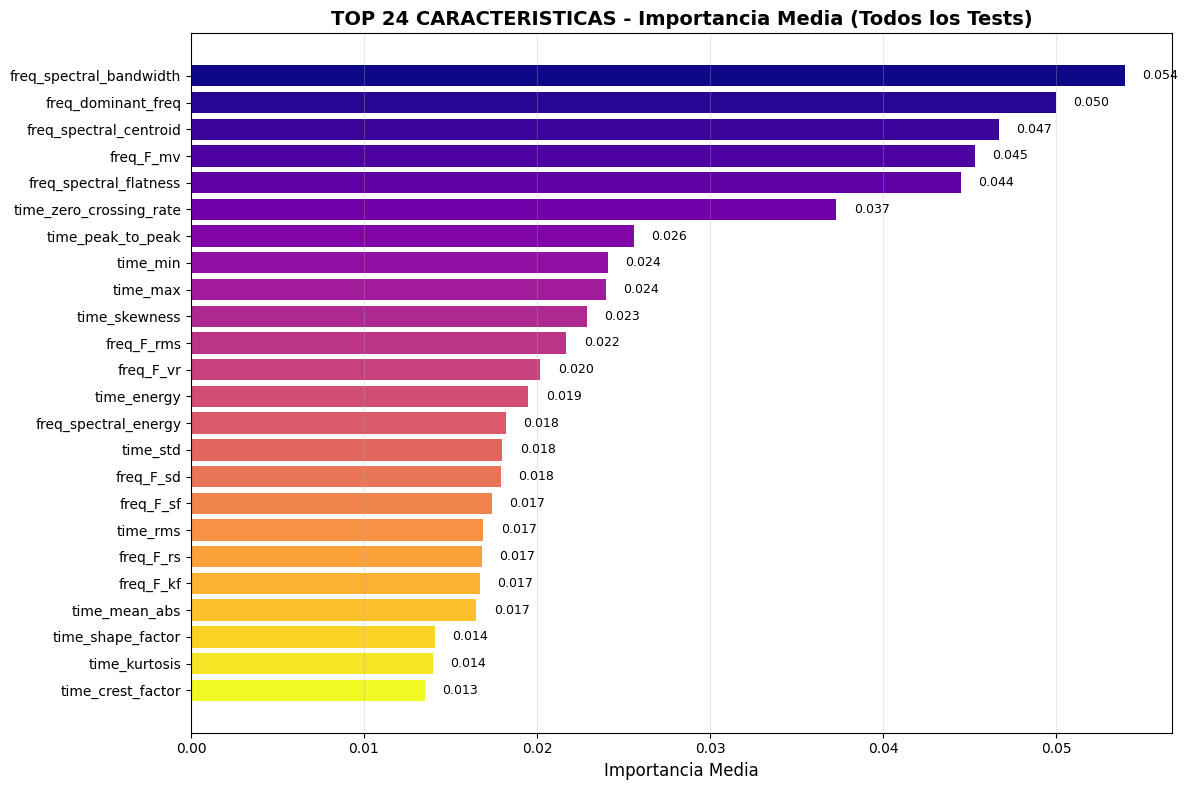

In [ ]:
def create_ranking_visualizations(df_importances_all):
    """
    Crea visualizaciones comprehensivas de los rankings de importancia
    
    Args:
        df_importances_all: DataFrame con importancias por test y frecuencia
    """
    
    # Configuración de estilo
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. TOP GLOBAL CONSIDERANDO TODOS LOS TESTS
    print("="*80)
    print("🏆 TOP GLOBAL DE FEATURES (TODOS LOS TESTS)")
    print("="*80)
    
    # Calcular score global sumando importancias
    global_importance = df_importances_all.groupby('Variable').agg({
        'Importancia': ['sum', 'mean', 'count']
    }).round(4)
    
    global_importance.columns = ['Importancia_Total', 'Importancia_Media', 'Apariciones']
    global_importance = global_importance.sort_values('Importancia_Media', ascending=False)
    
    # Mostrar top 24
    top_24_global = global_importance.head(24)
    print("\n📈 TOP 24 FEATURES GLOBALES:")
    for i, (feature, row) in enumerate(top_24_global.iterrows(), 1):
        print(f"   {i:2d}. {feature:<35} | Total: {row['Importancia_Total']:.4f} | Media: {row['Importancia_Media']:.4f} | Apariciones: {int(row['Apariciones'])}")
    
    # 2. CORRECCIÓN: Usar plt.subplots() en lugar de plt.figure()
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Crear gráfica de barras horizontales
    bars = ax.barh(range(len(top_24_global)), top_24_global['Importancia_Media'], 
                   color=plt.cm.plasma(np.linspace(0, 1, len(top_24_global))))
    
    # Configurar ejes y etiquetas
    ax.set_yticks(range(len(top_24_global)))
    ax.set_yticklabels(top_24_global.index, fontsize=10)
    ax.set_xlabel('Importancia Media', fontsize=12)
    ax.set_title('TOP 24 CARACTERISTICAS - Importancia Media (Todos los Tests)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Invertir el eje Y para que el más importante esté arriba
    ax.invert_yaxis()
    
    # Añadir valores en las barras
    for i, (bar, value) in enumerate(zip(bars, top_24_global['Importancia_Media'])):
        ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig("figs/top_variables_mas_importantes.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return global_importance

# Ejecutar la función
global_importance = create_ranking_visualizations(df_importances_all)

## Graficas

In [ ]:
def format_frequency_labels(freqs):
    """
    Formatea los labels de frecuencia para mejor legibilidad
    
    Args:
        freqs: lista de frecuencias
    
    Returns:
        lista de labels formateados
    """
    labels = []
    for freq in freqs:
        if freq >= 1000:
            if freq % 1000 == 0:
                labels.append(f'{int(freq/1000)}K')
            else:
                labels.append(f'{freq/1000:.1f}K')
        else:
            labels.append(f'{int(freq)}')
    return labels    


unique_freqs = sorted(df_performance['frecuencia_muestreo'].unique())
freq_labels = format_frequency_labels(unique_freqs)

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

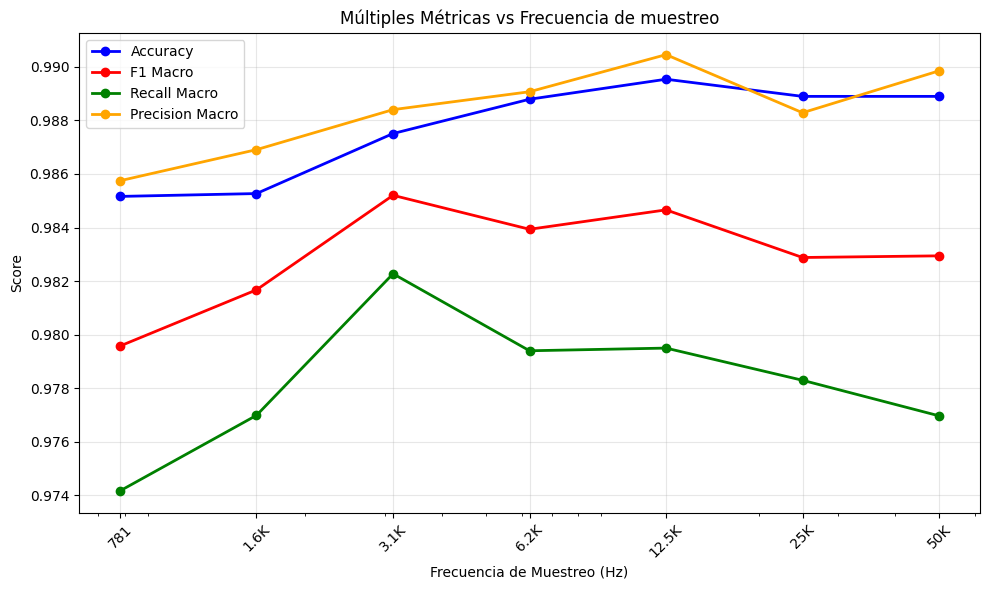

In [ ]:
# 2. MÚLTIPLES MÉTRICAS VS FRECUENCIA
plt.figure(figsize=(10, 6))
metrics_to_plot = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']
colors = ['blue', 'red', 'green', 'orange']

for metric, color in zip(metrics_to_plot, colors):
    metric_means = df_performance.groupby('frecuencia_muestreo')[metric].mean().reset_index()
    metric_means = metric_means.sort_values('frecuencia_muestreo')
    plt.plot(metric_means['frecuencia_muestreo'], metric_means[metric], 
                'o-', color=color, label=metric.replace('_', ' ').title(), linewidth=2)

plt.xlabel('Frecuencia de Muestreo (Hz)')
plt.ylabel('Score')
plt.title('Múltiples Métricas vs Frecuencia de muestreo')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xscale('log')
plt.xticks(unique_freqs, freq_labels, rotation=45)
plt.tight_layout()
plt.savefig("figs/metricas_vs_frecuencia.png")
plt.show()


📊 GRÁFICAS POR MÉTRICA COMPARANDO SENSORES

Generando gráfico para: Accuracy


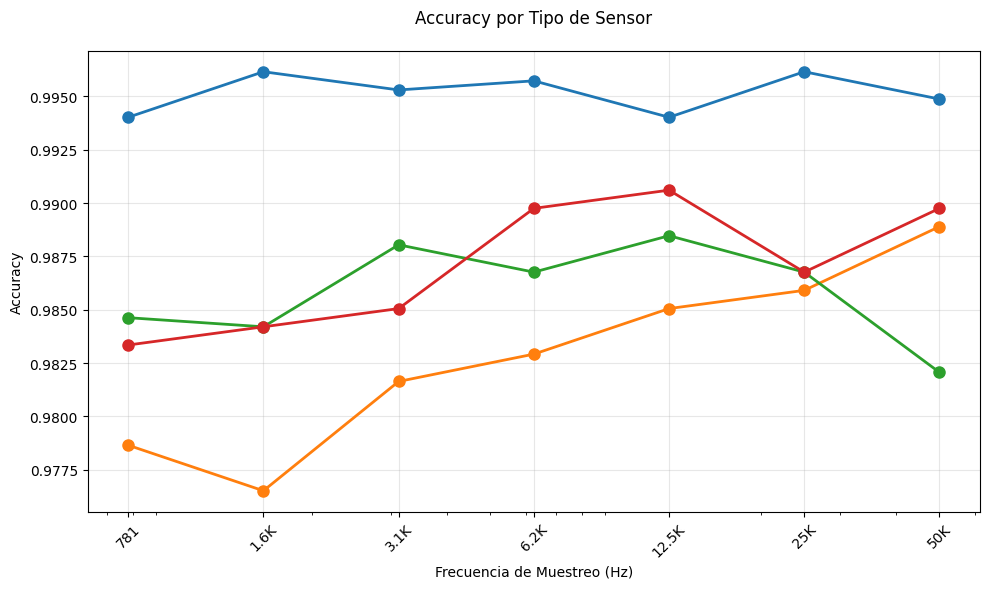


Generando gráfico para: F1 Macro


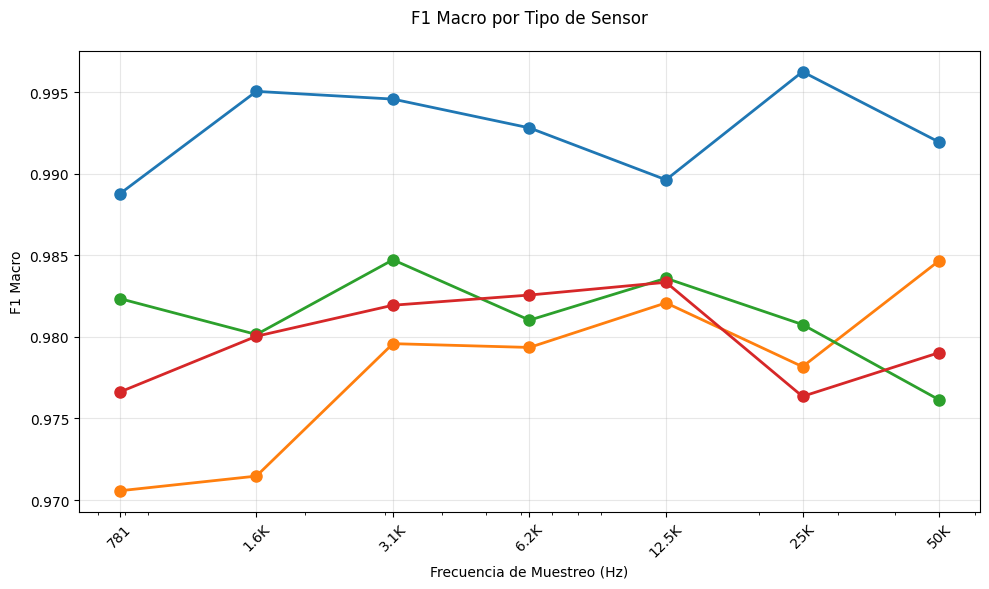


Generando gráfico para: Recall Macro


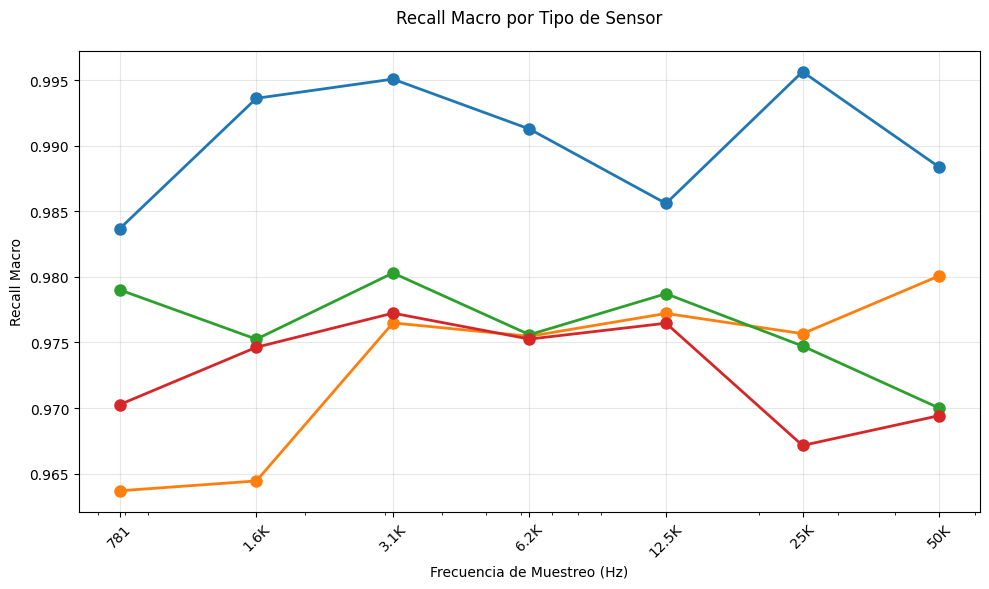


Generando gráfico para: Precision Macro


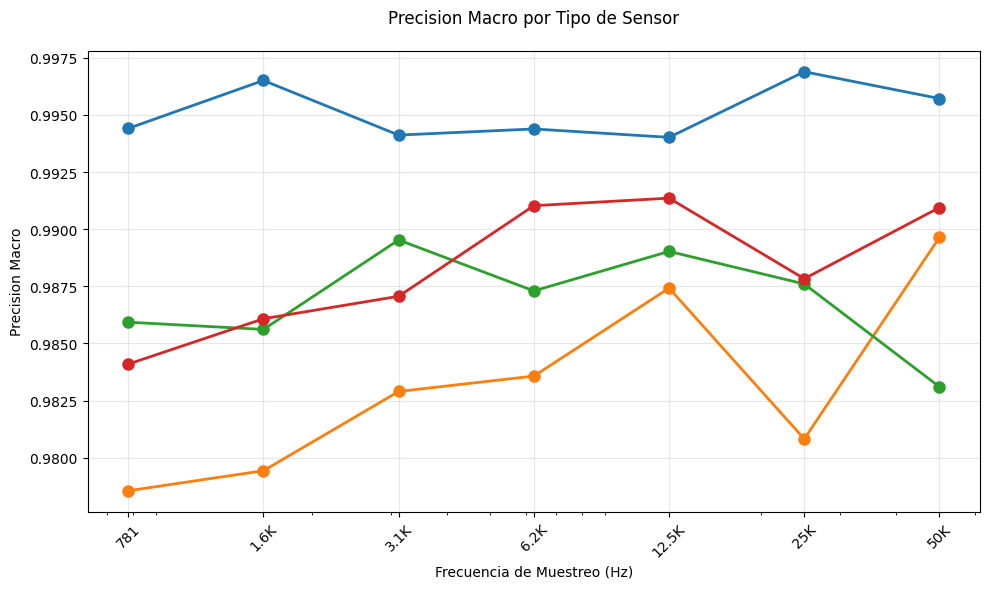

In [ ]:
# 3. GRÁFICAS SEPARADAS POR MÉTRICA COMPARANDO SENSORES
def plot_metric_by_sensor(df_performance, metric, unique_freqs, freq_labels):
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab10.colors  # Paleta de colores para los sensores
    
    for i, test in enumerate(df_performance['test'].unique()):
        test_data = df_performance[df_performance['test'] == test].sort_values('frecuencia_muestreo')
        plt.plot(test_data['frecuencia_muestreo'], test_data[metric], 
                'o-', color=colors[i % len(colors)],
                label=test, linewidth=2, markersize=8)
    
    plt.xlabel('Frecuencia de Muestreo (Hz)')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} por Tipo de Sensor', pad=20)
    plt.grid(True, alpha=0.3)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xscale('log')
    plt.xticks(unique_freqs, freq_labels, rotation=45)
    plt.tight_layout()
    plt.savefig(f"figs/{metric}_vs_frecuencia_por_sensor.png", bbox_inches='tight')
    plt.show()

# Configuración común
unique_freqs = sorted(df_performance['frecuencia_muestreo'].unique())
freq_labels = format_frequency_labels(unique_freqs)
metrics_to_plot = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']

# Generar gráficas para cada métrica
print("\n" + "="*80)
print("📊 GRÁFICAS POR MÉTRICA COMPARANDO SENSORES")
print("="*80)

for metric in metrics_to_plot:
    print(f"\nGenerando gráfico para: {metric.replace('_', ' ').title()}")
    plot_metric_by_sensor(df_performance, metric, unique_freqs, freq_labels)

### Heatmap Accuracy por tipo de sensores y Frecuencia de muestreo

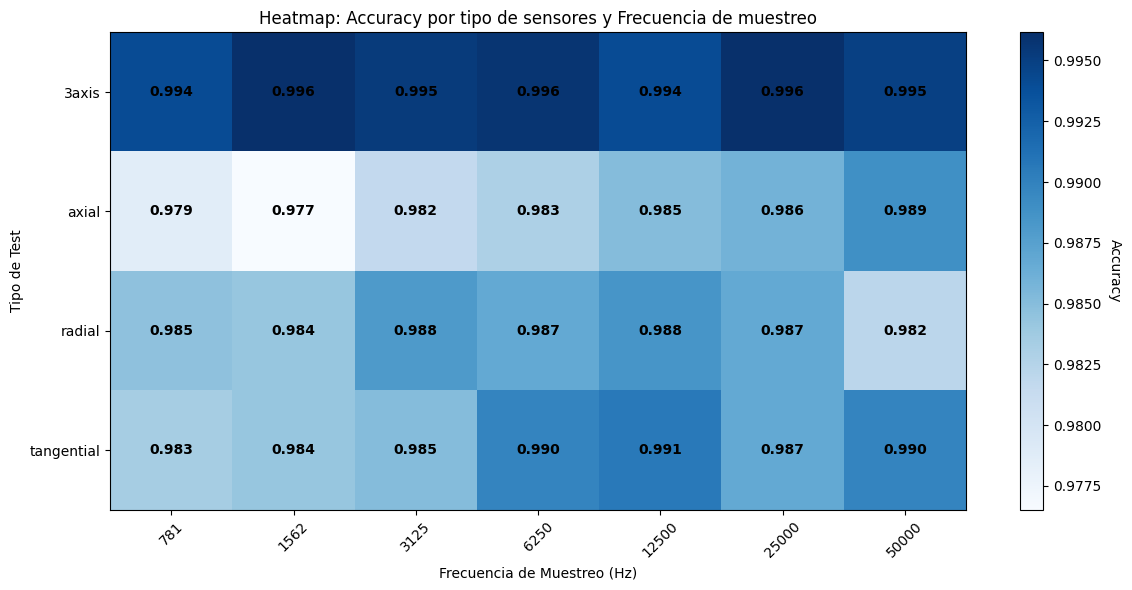

In [ ]:
# 3. HEATMAP DE DESEMPEÑO
plt.figure(figsize=(12, 6))
pivot_data = df_performance.pivot_table(
    index='test',
    columns='frecuencia_muestreo',
    values='accuracy',
    aggfunc='mean'
)

im = plt.imshow(pivot_data.values, cmap='Blues', aspect='auto')

plt.xticks(range(len(pivot_data.columns)), [f'{int(freq)}' for freq in pivot_data.columns], rotation=45)
plt.yticks(range(len(pivot_data.index)), pivot_data.index)

for i in range(len(pivot_data.index)):
    for j in range(len(pivot_data.columns)):
        value = pivot_data.iloc[i, j]
        if not pd.isna(value):
            plt.text(j, i, f'{value:.3f}', ha='center', va='center',
                        color='white' if value < 0.5 else 'black', fontweight='bold')

plt.title('Heatmap: Accuracy por tipo de sensores y Frecuencia de muestreo')
plt.xlabel('Frecuencia de Muestreo (Hz)')
plt.ylabel('Tipo de Test')
cbar = plt.colorbar(im)
cbar.set_label('Accuracy', rotation=270, labelpad=15)
plt.tight_layout()
plt.savefig("figs/heatmap_accuracy_vs_frecuencia")
plt.show()

## Análisis por tipo de frecuencia

In [ ]:
freq_summary = df_performance.groupby('frecuencia_muestreo').agg({
        'accuracy': ['mean', 'std', 'min', 'max'],
        "precision_macro": ['mean', 'std', 'min', 'max'],
        'recall_macro': ['mean', 'std', 'min', 'max'],
        'f1_macro': ['mean', 'std', 'min', 'max'],
    }).round(4)
# Aplanar columnas multi-nivel
freq_summary.columns = ['_'.join(col).strip() for col in freq_summary.columns.values]
freq_summary

accuracy_mean  accuracy_std  accuracy_min  accuracy_max  \
frecuencia_muestreo                                                            
781                         0.9852        0.0064        0.9787        0.9940   
1562                        0.9853        0.0081        0.9765        0.9962   
3125                        0.9875        0.0058        0.9816        0.9953   
6250                        0.9888        0.0054        0.9829        0.9957   
12500                       0.9895        0.0038        0.9851        0.9940   
25000                       0.9889        0.0049        0.9859        0.9962   
50000                       0.9889        0.0053        0.9821        0.9949   

                     precision_macro_mean  precision_macro_std  \
frecuencia_muestreo                                              
781                                0.9857               0.0066   
1562                               0.9869               0.0071   
3125                               0.9884               0.0047   
6250                               0.9891               0.0047   
12500                              0.9905               0.0029   
25000                              0.9883               0.0066   
50000                              0.9899               0.0052   

                     precision_macro_min  precision_macro_max  \
frecuencia_muestreo                                             
781                               0.9786               0.9944   
1562                              0.9794               0.9965   
3125                              0.9829               0.9941   
6250                              0.9836               0.9944   
12500                             0.9874               0.9940   
25000                             0.9808               0.9969   
50000                             0.9831               0.9957   

                     recall_macro_mean  recall_macro_std  recall_macro_min  \
frecuencia_muestreo                                                          
781                             0.9742            0.0089            0.9637   
1562                            0.9770            0.0121            0.9644   
3125                            0.9823            0.0087            0.9765   
6250                            0.9794            0.0079            0.9753   
12500                           0.9795            0.0042            0.9765   
25000                           0.9783            0.0122            0.9671   
50000                           0.9770            0.0090            0.9694   

                     recall_macro_max  f1_macro_mean  f1_macro_std  \
frecuencia_muestreo                                                  
781                            0.9837         0.9796        0.0078   
1562                           0.9936         0.9817        0.0098   
3125                           0.9951         0.9852        0.0066   
6250                           0.9913         0.9839        0.0061   
12500                          0.9856         0.9847        0.0034   
25000                          0.9956         0.9829        0.0091   
50000                          0.9884         0.9829        0.0070   

                     f1_macro_min  f1_macro_max  
frecuencia_muestreo                              
781                        0.9706        0.9888  
1562                       0.9715        0.9950  
3125                       0.9796        0.9946  
6250                       0.9794        0.9928  
12500                      0.9821        0.9896  
25000                      0.9763        0.9962  
50000                      0.9761        0.9919

In [ ]:
for test, row in freq_summary.iterrows():
        linea1 = f"   {test:>12} | Accuracy: {row['accuracy_mean']:.4f} ± {row['accuracy_std']:.4f} | F1 macro: {row['f1_macro_mean']:.4f} ± {row['f1_macro_mean']:.4f}"
        linea2 = f" | Recall macro: {row['recall_macro_mean']:.4f} ± {row['recall_macro_std']:.4f} | Precision macro: {row['precision_macro_mean']:.4f} ± {row['precision_macro_std']:.4f}"
        print(linea1 + linea2)

            781 | Accuracy: 0.9852 ± 0.0064 | F1 macro: 0.9796 ± 0.9796 | Recall macro: 0.9742 ± 0.0089 | Precision macro: 0.9857 ± 0.0066
           1562 | Accuracy: 0.9853 ± 0.0081 | F1 macro: 0.9817 ± 0.9817 | Recall macro: 0.9770 ± 0.0121 | Precision macro: 0.9869 ± 0.0071
           3125 | Accuracy: 0.9875 ± 0.0058 | F1 macro: 0.9852 ± 0.9852 | Recall macro: 0.9823 ± 0.0087 | Precision macro: 0.9884 ± 0.0047
           6250 | Accuracy: 0.9888 ± 0.0054 | F1 macro: 0.9839 ± 0.9839 | Recall macro: 0.9794 ± 0.0079 | Precision macro: 0.9891 ± 0.0047
          12500 | Accuracy: 0.9895 ± 0.0038 | F1 macro: 0.9847 ± 0.9847 | Recall macro: 0.9795 ± 0.0042 | Precision macro: 0.9905 ± 0.0029
          25000 | Accuracy: 0.9889 ± 0.0049 | F1 macro: 0.9829 ± 0.9829 | Recall macro: 0.9783 ± 0.0122 | Precision macro: 0.9883 ± 0.0066
          50000 | Accuracy: 0.9889 ± 0.0053 | F1 macro: 0.9829 ± 0.9829 | Recall macro: 0.9770 ± 0.0090 | Precision macro: 0.9899 ± 0.0052


In [ ]:
# 2. ANOVA TEST - ¿Hay diferencias significativas entre frecuencias?
print(f"\n🧪 ANÁLISIS DE VARIANZA (ANOVA):")
print("-" * 40)

from scipy.stats import f_oneway

# Agrupar por frecuencia para ANOVA
freq_groups = []
freq_labels = []

for freq in sorted(df_performance['frecuencia_muestreo'].unique()):
    freq_data = df_performance[df_performance['frecuencia_muestreo'] == freq]
    if len(freq_data) > 1:  # Solo si hay múltiples observaciones
        freq_groups.append(freq_data['accuracy'].values)
        freq_labels.append(freq)

if len(freq_groups) > 2:
    f_stat, p_value = f_oneway(*freq_groups)
    print(f"   F-statistic: {f_stat:.4f}")
    print(f"   P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("   🔍 RESULTADO: Hay diferencias significativas entre frecuencias (p < 0.05)")
    else:
        print("   ❌ RESULTADO: No hay diferencias significativas entre frecuencias (p ≥ 0.05)")



🧪 ANÁLISIS DE VARIANZA (ANOVA):
----------------------------------------
   F-statistic: 0.3924
   P-value: 0.8756
   ❌ RESULTADO: No hay diferencias significativas entre frecuencias (p ≥ 0.05)


In [ ]:
import pandas as pd
import pingouin as pg
from scipy.stats import friedmanchisquare

# 1. Preparación de datos para ANOVA de medidas repetidas
# Asumiendo que cada 'test' (sensor) es un bloque/sujeto
print("\n🧪 ANOVA DE MEDIDAS REPETIDAS (Frecuencias como condiciones)")
print("-"*60)

# Seleccionar métrica de interés (ej. accuracy)
metric = 'accuracy'

# Crear dataframe largo a ancho (pivot)
df_wide = df_performance.pivot(index='test', 
                              columns='frecuencia_muestreo', 
                              values=metric)

# 2. Verificación de supuestos
print("\n🔍 Verificación de supuestos:")
# Normalidad (Shapiro-Wilk por frecuencia)
norm_results = pg.normality(df_performance, dv=metric, group='frecuencia_muestreo')
print("Resultados del test de normalidad por frecuencia:")
print(norm_results[['W', 'pval', 'normal']].round(4))

# Esfericidad (se verificará automáticamente en pingouin)

# 3. ANOVA de medidas repetidas
rm_anova = pg.rm_anova(data=df_performance, 
                       dv=metric, 
                       within='frecuencia_muestreo', 
                       subject='test',
                       detailed=True)

print("\n📊 Resultados ANOVA de Medidas Repetidas:")
print(rm_anova.round(4))

# 4. Post-hoc si resultado significativo
if rm_anova['p-unc'][0] < 0.05:
    print("\n🔎 Comparaciones post-hoc (pairwise t-tests con corrección Bonferroni):")
    posthoc = pg.pairwise_tests(data=df_performance,
                               dv=metric,
                               within='frecuencia_muestreo',
                               subject='test',
                               padjust='bonf')
    print(posthoc.round(4))

# 5. Alternativa no paramétrica (Test de Friedman)
print("\n🔄 Test de Friedman (no paramétrico):")
friedman_data = [df_performance[df_performance['frecuencia_muestreo']==f][metric] 
                 for f in df_performance['frecuencia_muestreo'].unique()]

if len(friedman_data) > 2:
    friedman_stat, friedman_p = friedmanchisquare(*friedman_data)
    print(f"   Estadístico: {friedman_stat:.4f}")
    print(f"   P-value: {friedman_p:.4f}")
    print("   Resultado significativo" if friedman_p < 0.05 else "   No significativo")


🧪 ANOVA DE MEDIDAS REPETIDAS (Frecuencias como condiciones)
------------------------------------------------------------

🔍 Verificación de supuestos:
Resultados del test de normalidad por frecuencia:
                          W    pval  normal
frecuencia_muestreo                        
50000                0.9626  0.7950    True
25000                0.7012  0.0120   False
12500                1.0000  1.0000    True
6250                 0.9869  0.9413    True
3125                 0.9632  0.7988    True
1562                 0.9229  0.5531    True
781                  0.9331  0.6128    True
Resultados del test de normalidad por frecuencia:
                          W    pval  normal
frecuencia_muestreo                        
50000                0.9626  0.7950    True
25000                0.7012  0.0120   False
12500                1.0000  1.0000    True
6250                 0.9869  0.9413    True
3125                 0.9632  0.7988    True
1562                 0.9229  0.5531    True


c:\Users\maril\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


## Análisis por tipo de sensor

In [ ]:
test_performance = df_performance.groupby('test').agg({
        'accuracy': ['mean', 'std', 'min', 'max'],
        "precision_macro": ['mean', 'std', 'min', 'max'],
        'recall_macro': ['mean', 'std', 'min', 'max'],
        'f1_macro': ['mean', 'std', 'min', 'max'],
    }).round(4)

test_performance.columns = ['_'.join(col).strip() for col in test_performance.columns.values]
test_performance_sorted = test_performance.sort_values('accuracy_mean', ascending=False)
test_performance

accuracy_mean  accuracy_std  accuracy_min  accuracy_max  \
test                                                                  
3axis              0.9952        0.0009        0.9940        0.9962   
axial              0.9828        0.0043        0.9765        0.9889   
radial             0.9858        0.0023        0.9821        0.9885   
tangential         0.9871        0.0030        0.9833        0.9906   

            precision_macro_mean  precision_macro_std  precision_macro_min  \
test                                                                         
3axis                     0.9951               0.0012               0.9940   
axial                     0.9832               0.0041               0.9786   
radial                    0.9869               0.0022               0.9831   
tangential                0.9883               0.0028               0.9841   

            precision_macro_max  recall_macro_mean  recall_macro_std  \
test                                                                   
3axis                    0.9969             0.9905            0.0047   
axial                    0.9896             0.9733            0.0065   
radial                   0.9895             0.9762            0.0035   
tangential               0.9914             0.9729            0.0039   

            recall_macro_min  recall_macro_max  f1_macro_mean  f1_macro_std  \
test                                                                          
3axis                 0.9837            0.9956         0.9927        0.0028   
axial                 0.9637            0.9801         0.9780        0.0052   
radial                0.9700            0.9803         0.9812        0.0028   
tangential            0.9671            0.9772         0.9800        0.0028   

            f1_macro_min  f1_macro_max  
test                                    
3axis             0.9888        0.9962  
axial             0.9706        0.9847  
radial            0.9761        0.9847  
tangential        0.9763        0.9833

In [ ]:
for test, row in test_performance.iterrows():
        linea1 = f"   {test:>12} | Accuracy: {row['accuracy_mean']:.4f} ± {row['accuracy_std']:.4f} | F1 macro: {row['f1_macro_mean']:.4f} ± {row['f1_macro_mean']:.4f}"
        linea2 = f" | Recall macro: {row['recall_macro_mean']:.4f} ± {row['recall_macro_std']:.4f} | Precision macro: {row['precision_macro_mean']:.4f} ± {row['precision_macro_std']:.4f}"
        print(linea1 + linea2)
    

          3axis | Accuracy: 0.9952 ± 0.0009 | F1 macro: 0.9927 ± 0.9927 | Recall macro: 0.9905 ± 0.0047 | Precision macro: 0.9951 ± 0.0012
          axial | Accuracy: 0.9828 ± 0.0043 | F1 macro: 0.9780 ± 0.9780 | Recall macro: 0.9733 ± 0.0065 | Precision macro: 0.9832 ± 0.0041
         radial | Accuracy: 0.9858 ± 0.0023 | F1 macro: 0.9812 ± 0.9812 | Recall macro: 0.9762 ± 0.0035 | Precision macro: 0.9869 ± 0.0022
     tangential | Accuracy: 0.9871 ± 0.0030 | F1 macro: 0.9800 ± 0.9800 | Recall macro: 0.9729 ± 0.0039 | Precision macro: 0.9883 ± 0.0028


## Analsis por clase

In [ ]:
# Diccionario de clases
class_dict = {
    0: 'normal',
    1: 'desalineamiento vertical',
    2: 'desalineamiento horizontal', 
    3: 'desbalanceo',
    4: 'falla en jaula - rodamiento',
    5: 'falla en bola - rodamiento',
    6: 'falla en pista externa -rodamiento'
}

In [ ]:
# Preparar los datos
classes = sorted({k for v in all_results.values() for k in v['metrics']['test'].keys() 
                 if k.isdigit()})
metrics = ['precision', 'recall', 'f1-score']

# Crear un DataFrame con todos los resultados
data = []
for (sensor, freq), results in all_results.items():
    for class_id in classes:
        if class_id in results['metrics']['test']:
            row = {
                'sensor': sensor,
                'freq': freq,
                'class': class_id,
                **results['metrics']['test'][class_id]
            }
            data.append(row)

df = pd.DataFrame(data)
df

sensor   freq class  precision    recall  f1-score  support
0         3axis  50000     0   1.000000  0.949153  0.973913     59.0
1         3axis  50000     1   1.000000  0.983051  0.991453    236.0
2         3axis  50000     2   0.988920  0.988920  0.988920    361.0
3         3axis  50000     3   0.995012  0.997500  0.996255    400.0
4         3axis  50000     4   0.994872  1.000000  0.997429    388.0
..          ...    ...   ...        ...       ...       ...      ...
191  tangential    781     2   0.980663  0.983380  0.982019    361.0
192  tangential    781     3   0.968293  0.992500  0.980247    400.0
193  tangential    781     4   1.000000  1.000000  1.000000    388.0
194  tangential    781     5   0.991111  0.988914  0.990011    451.0
195  tangential    781     6   0.986425  0.975391  0.980877    447.0

[196 rows x 7 columns]


📊 ANÁLISIS DE DESEMPEÑO POR CLASE

🔍 Clase 0:
  - Generando gráfico para precision


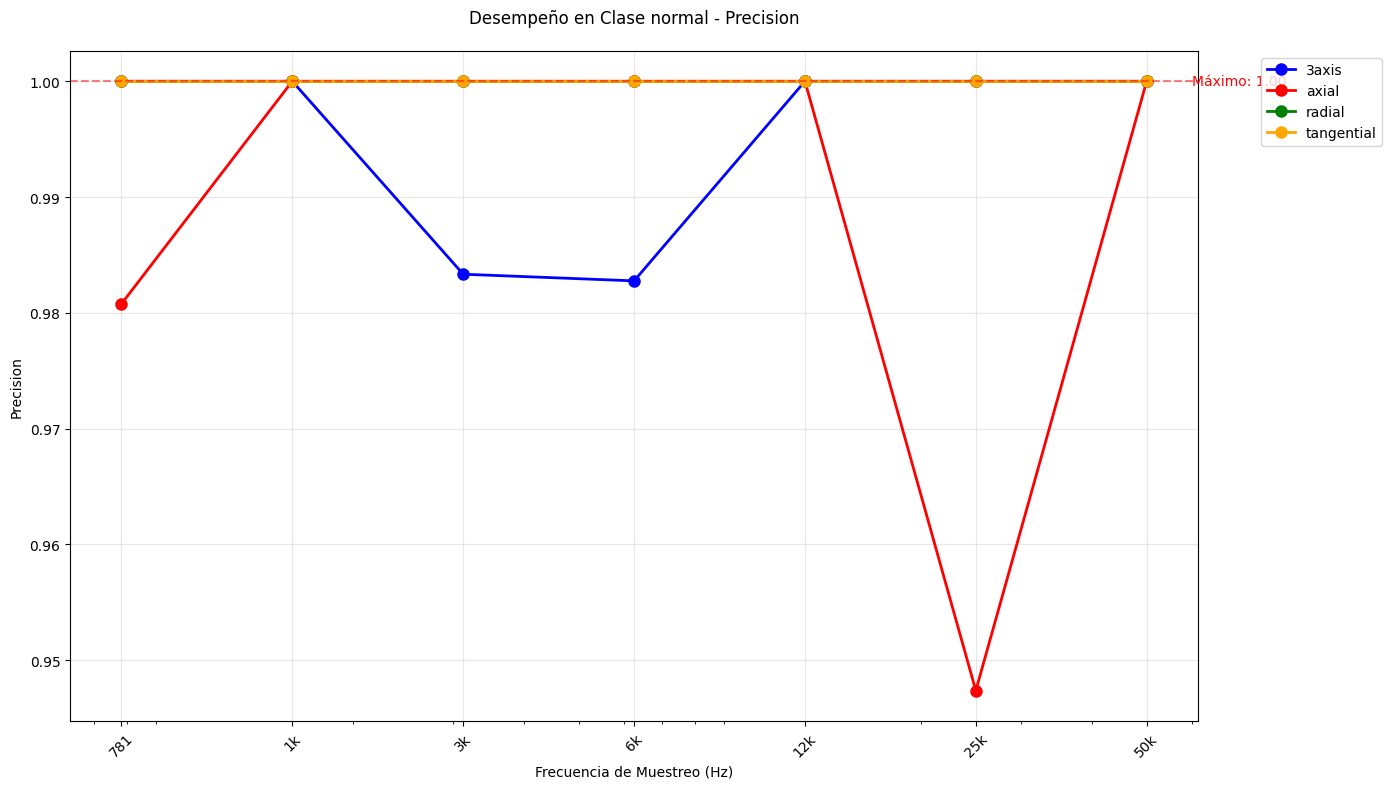

  - Generando gráfico para recall


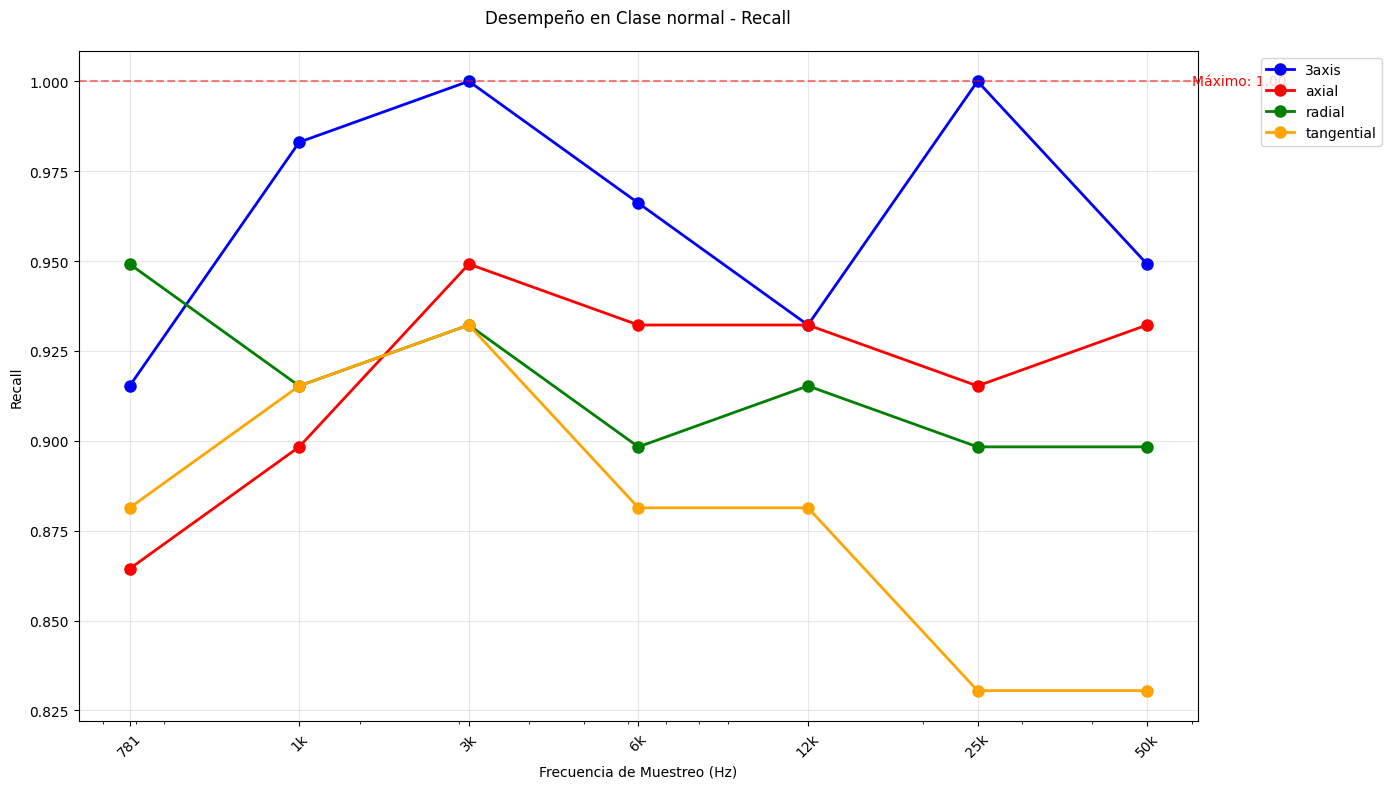

  - Generando gráfico para f1 score


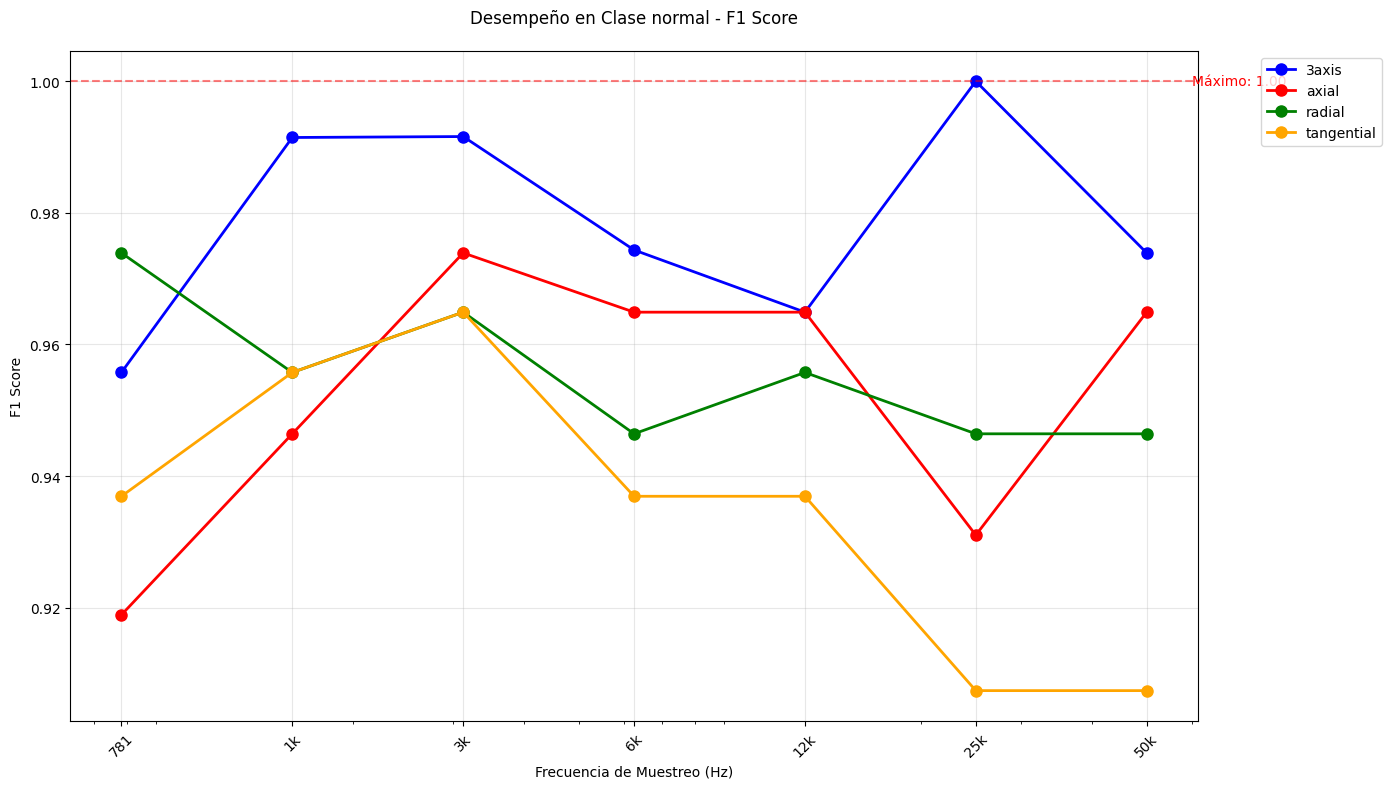


🔍 Clase 1:
  - Generando gráfico para precision


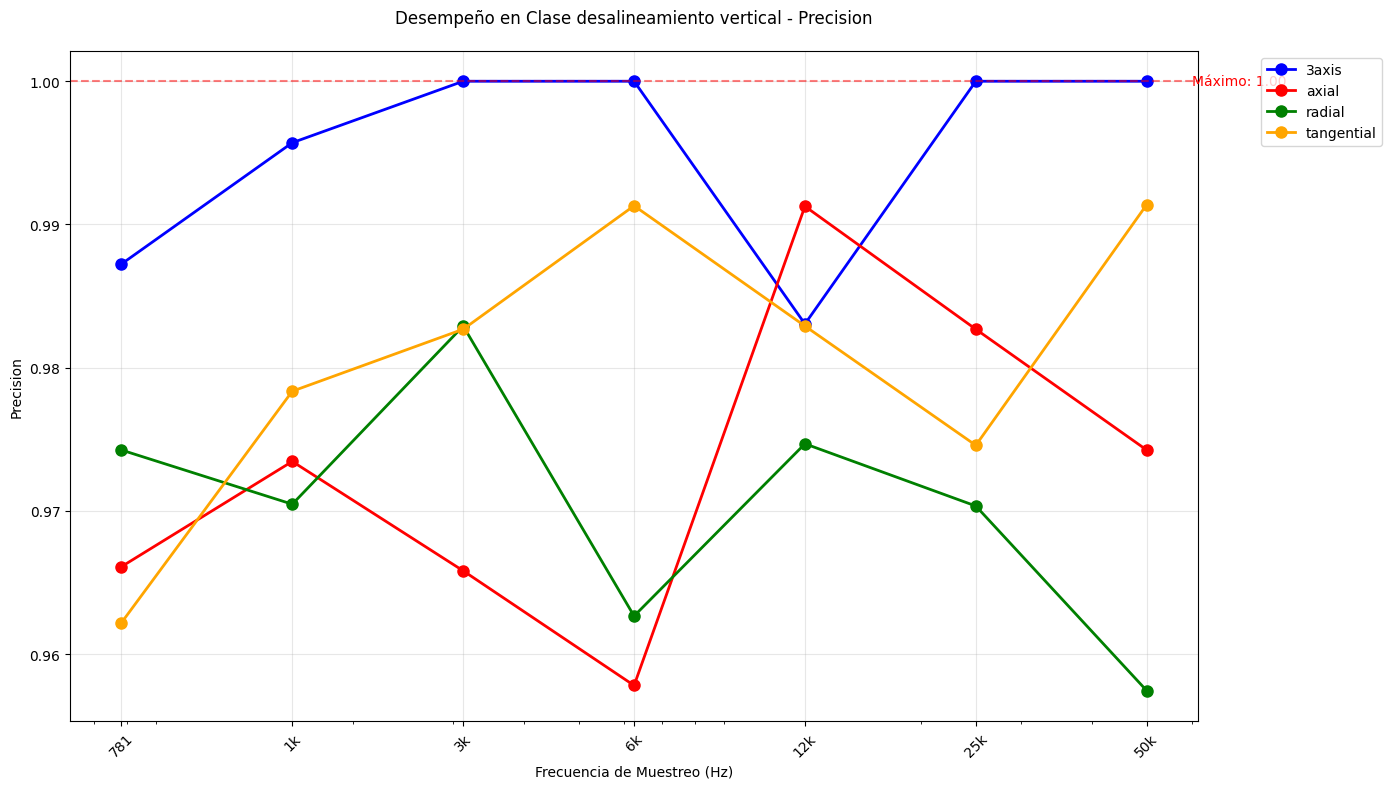

  - Generando gráfico para recall


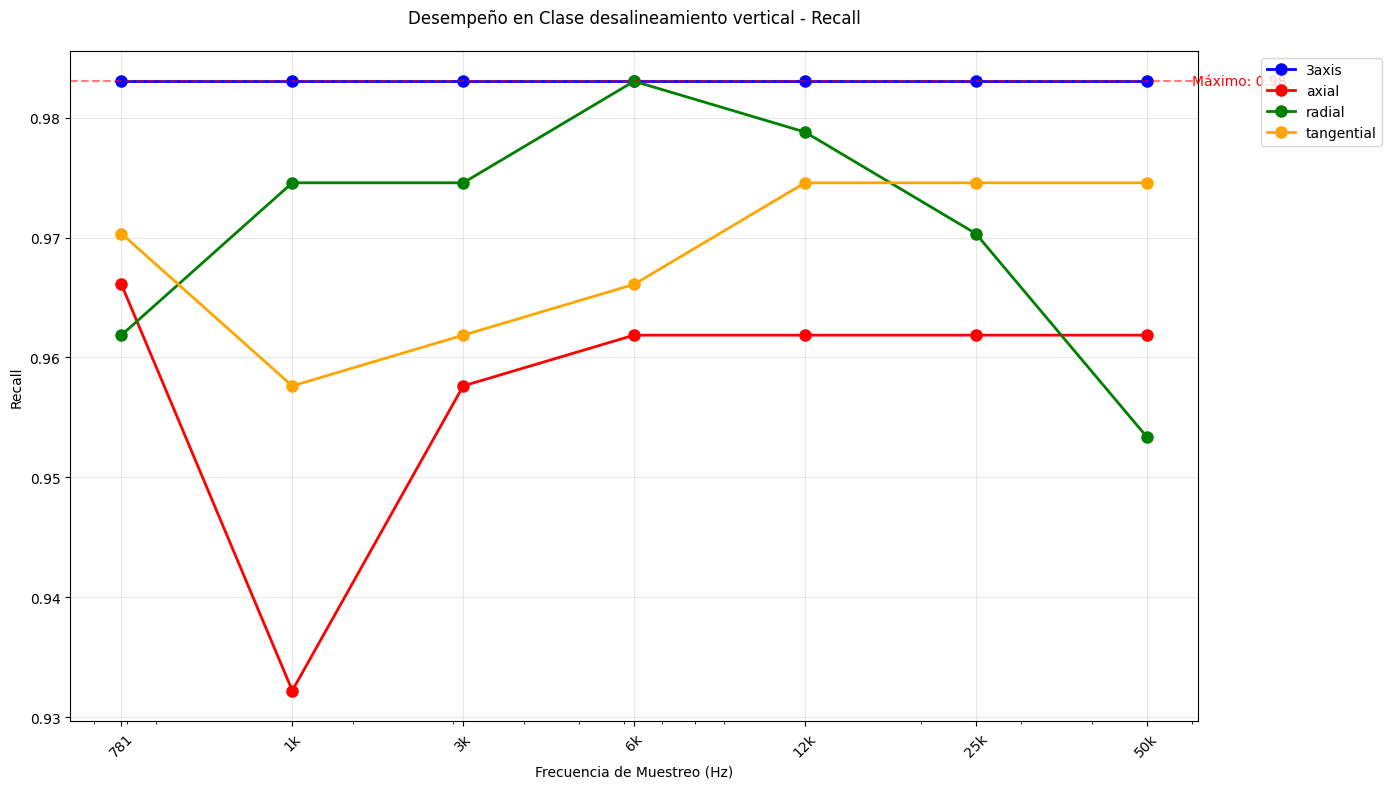

  - Generando gráfico para f1 score


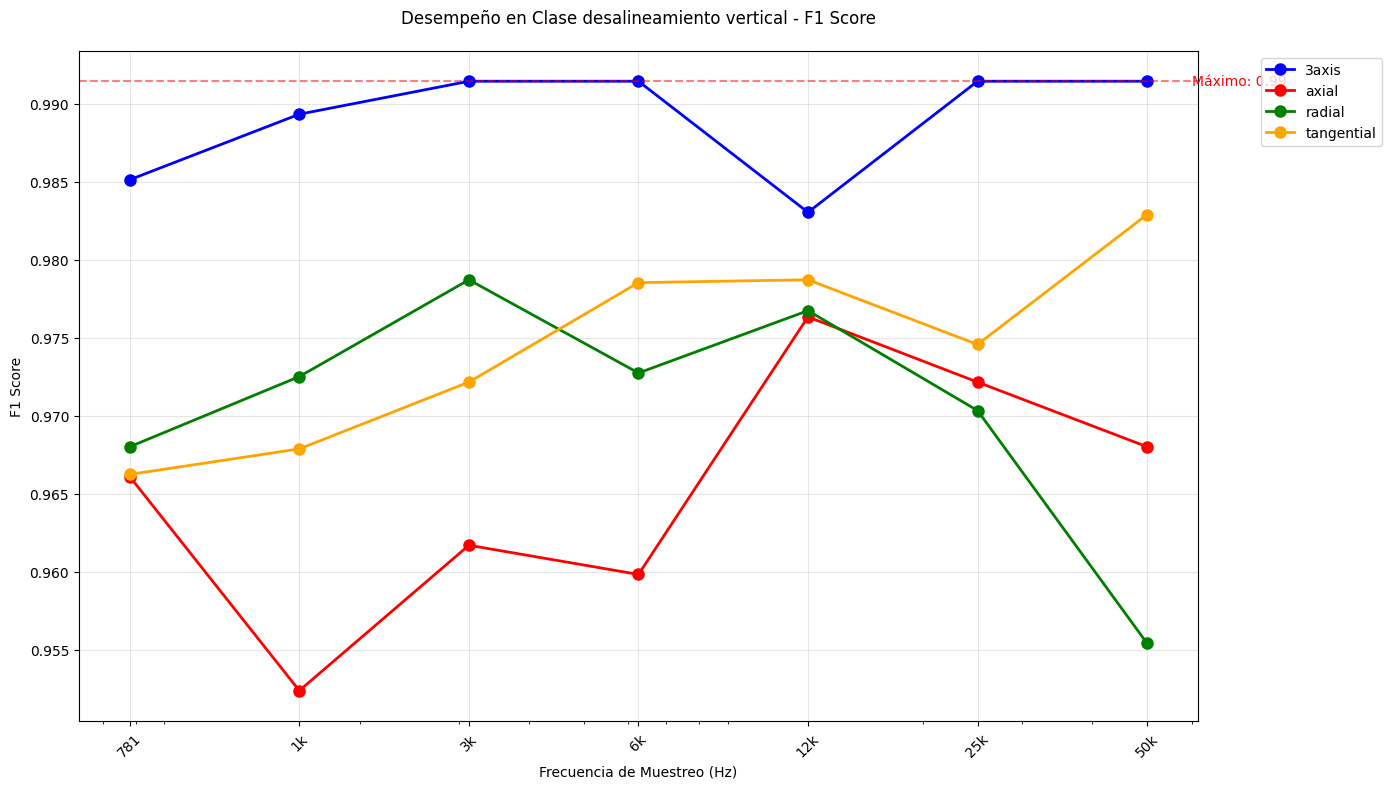


🔍 Clase 2:
  - Generando gráfico para precision


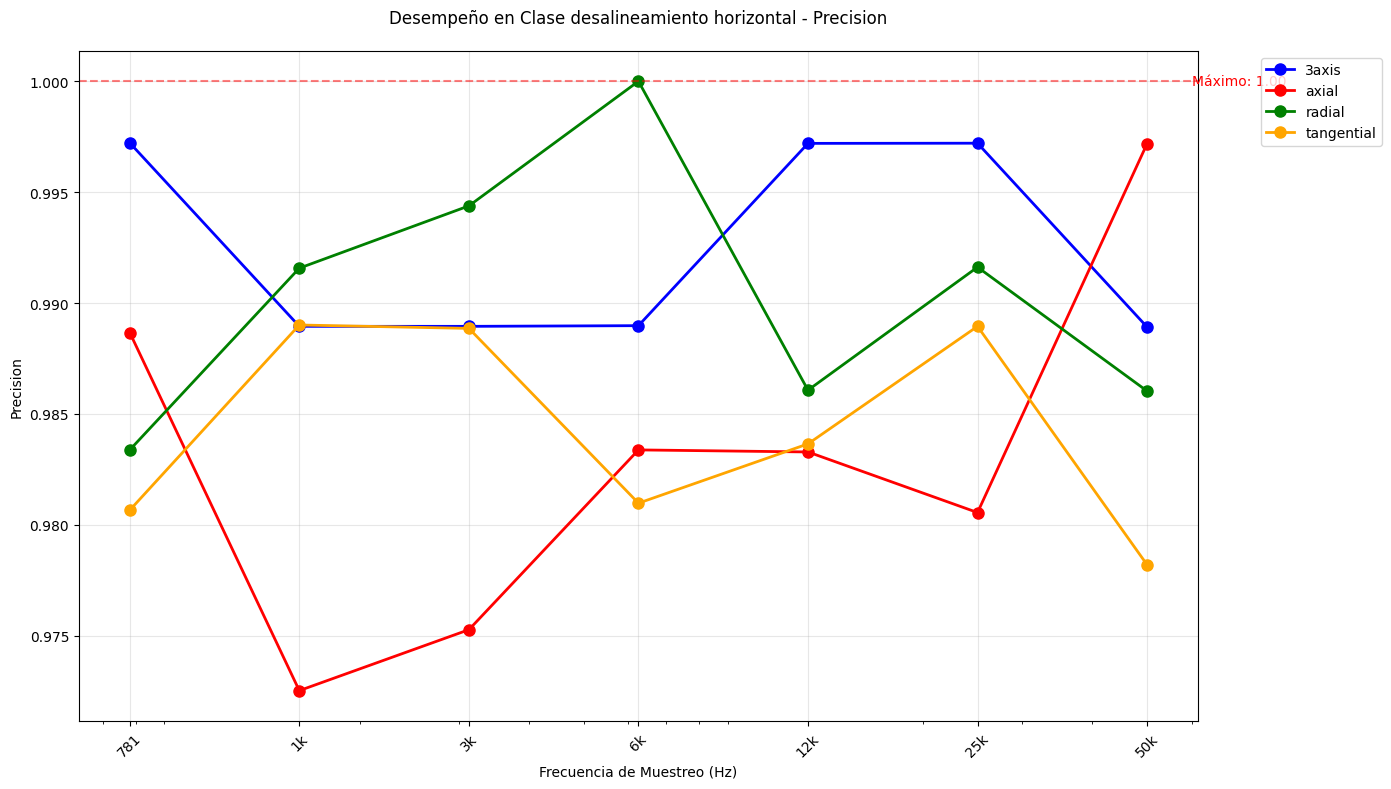

  - Generando gráfico para recall


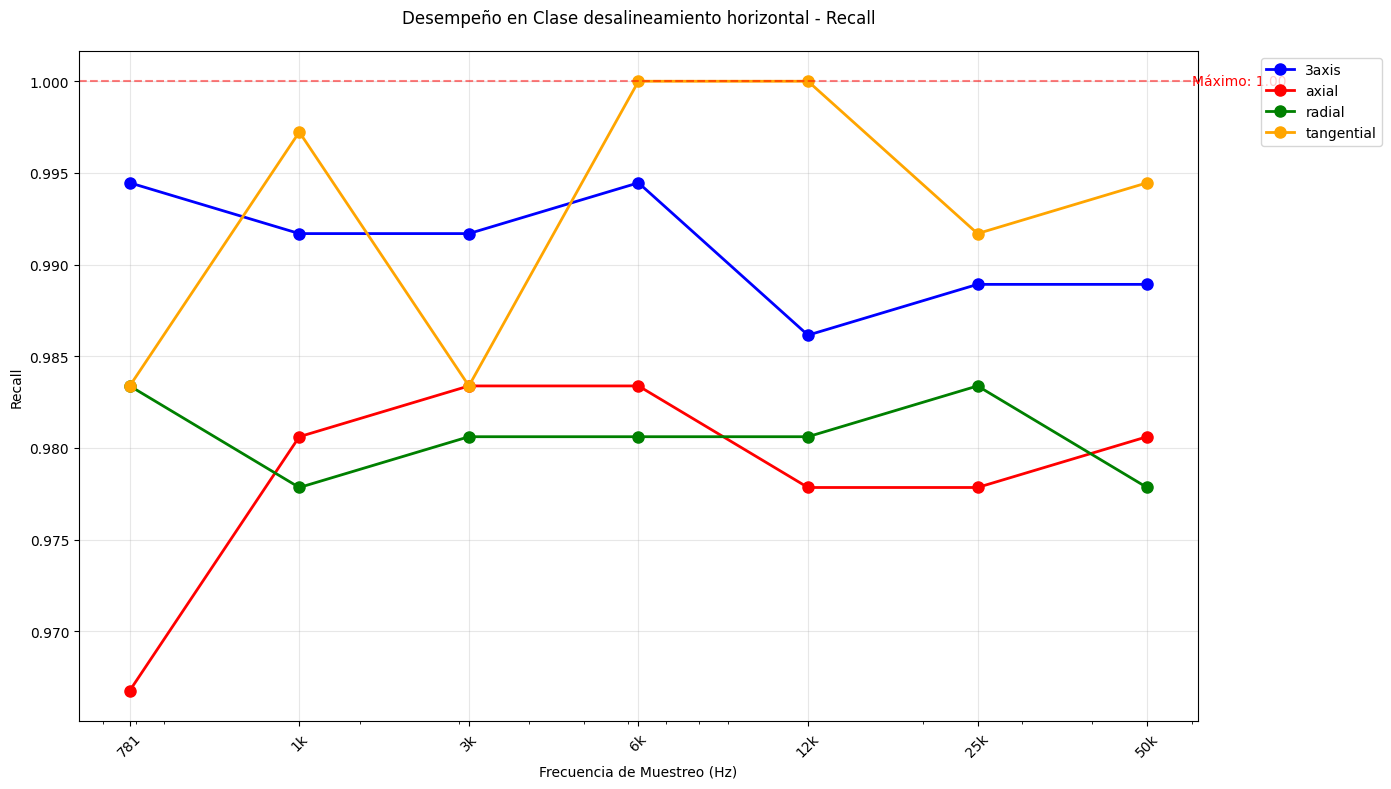

  - Generando gráfico para f1 score


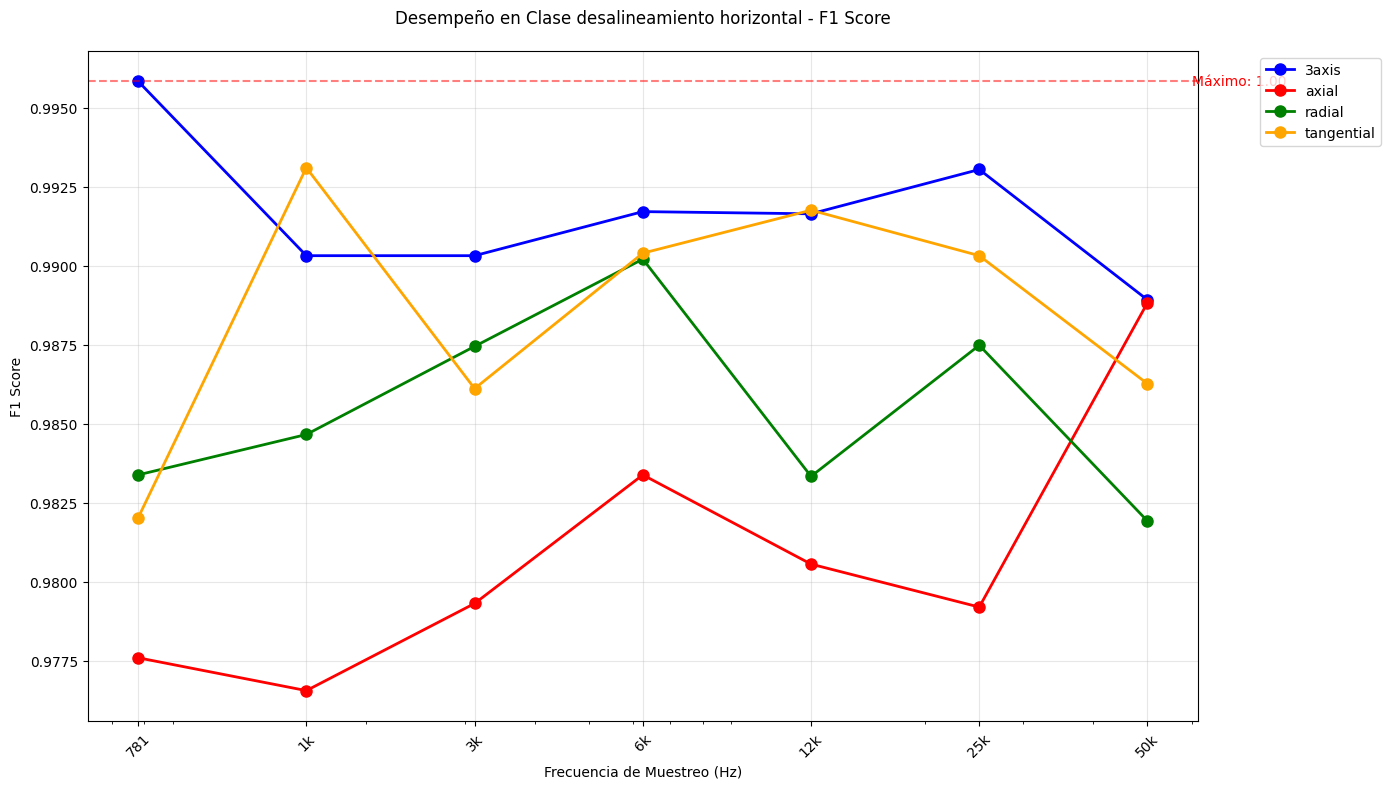


🔍 Clase 3:
  - Generando gráfico para precision


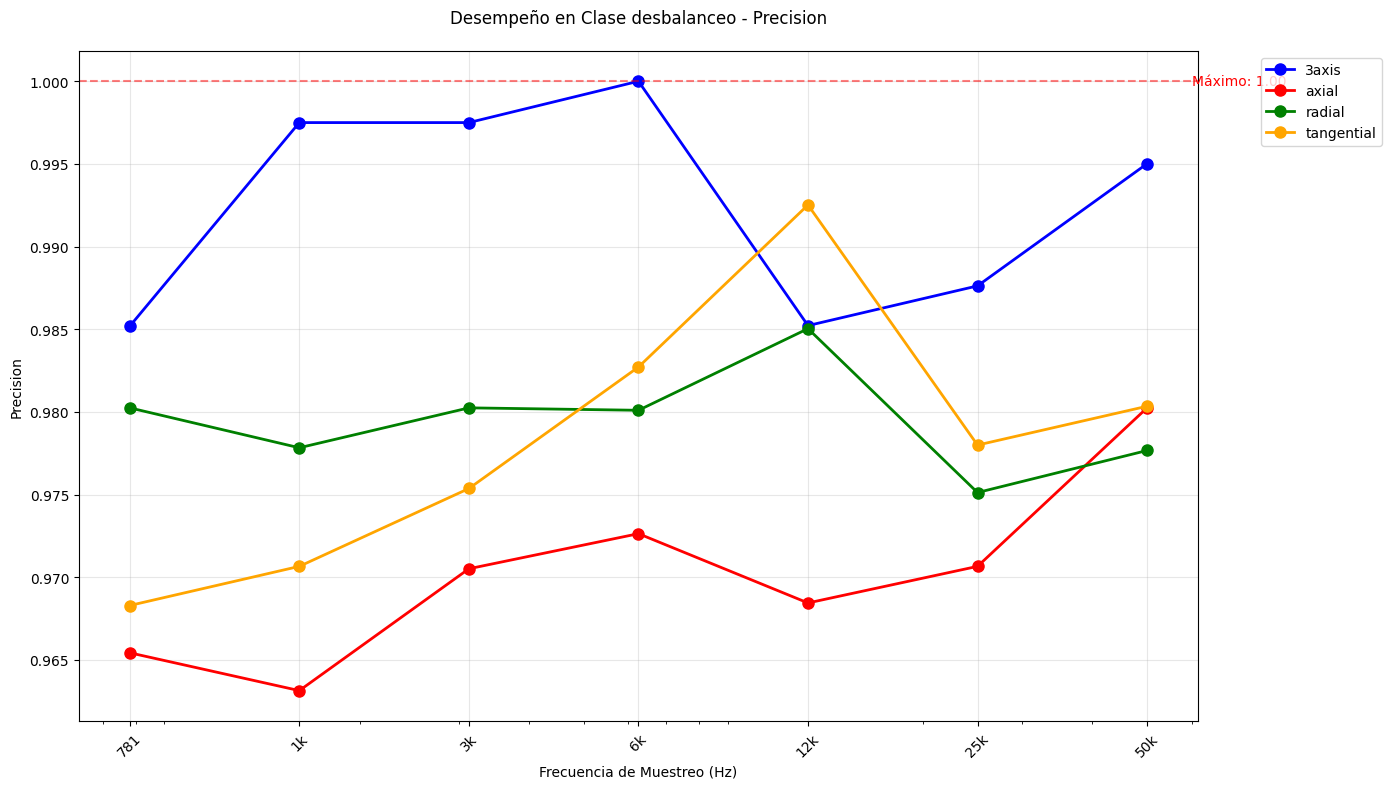

  - Generando gráfico para recall


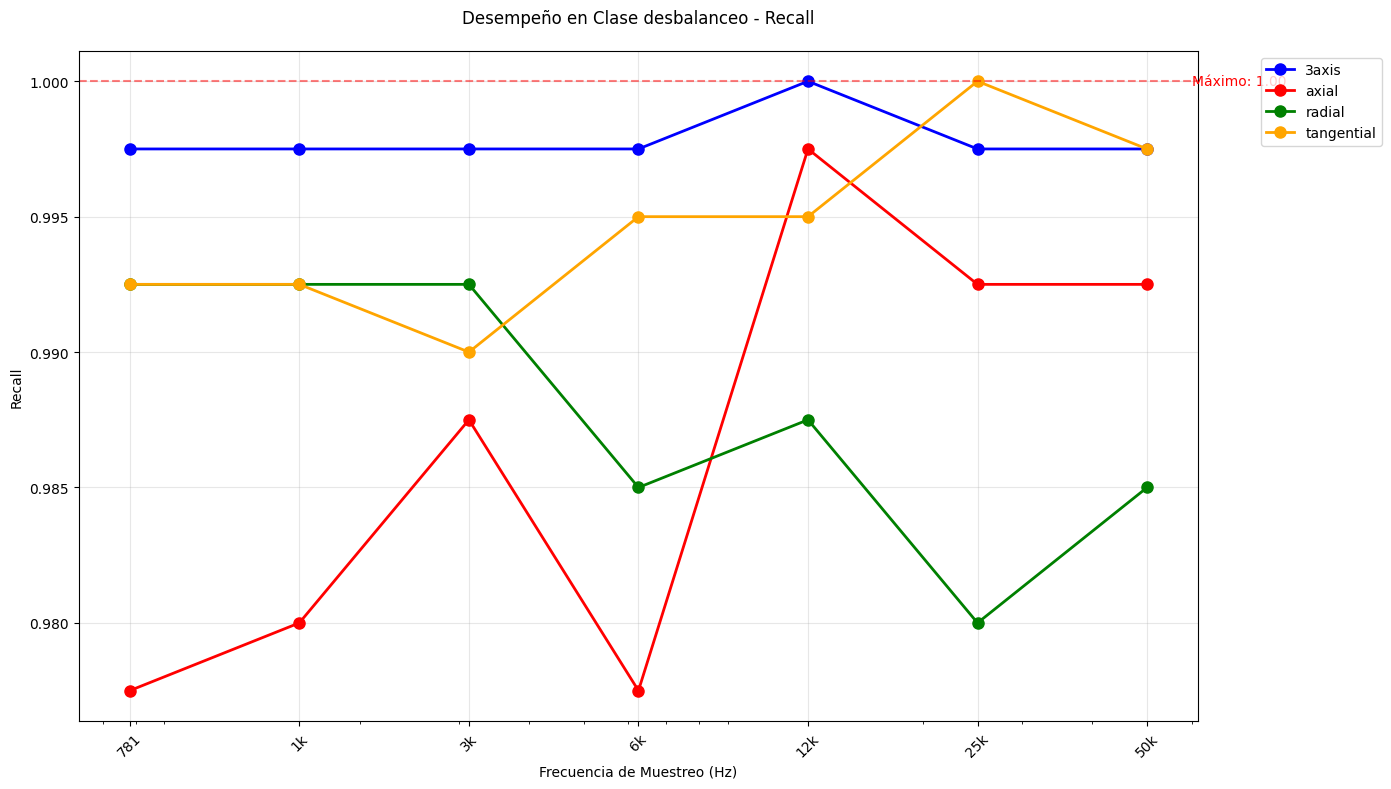

  - Generando gráfico para f1 score


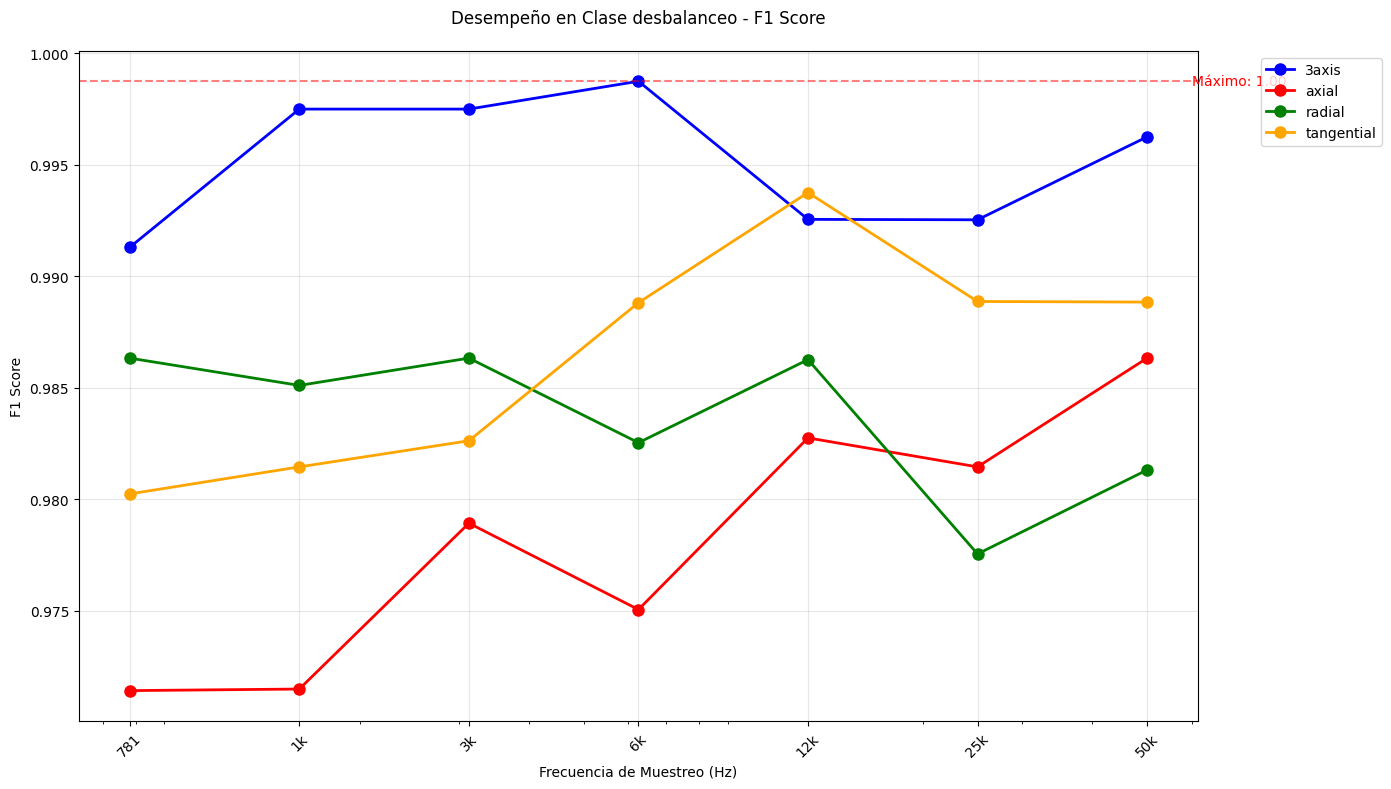


🔍 Clase 4:
  - Generando gráfico para precision


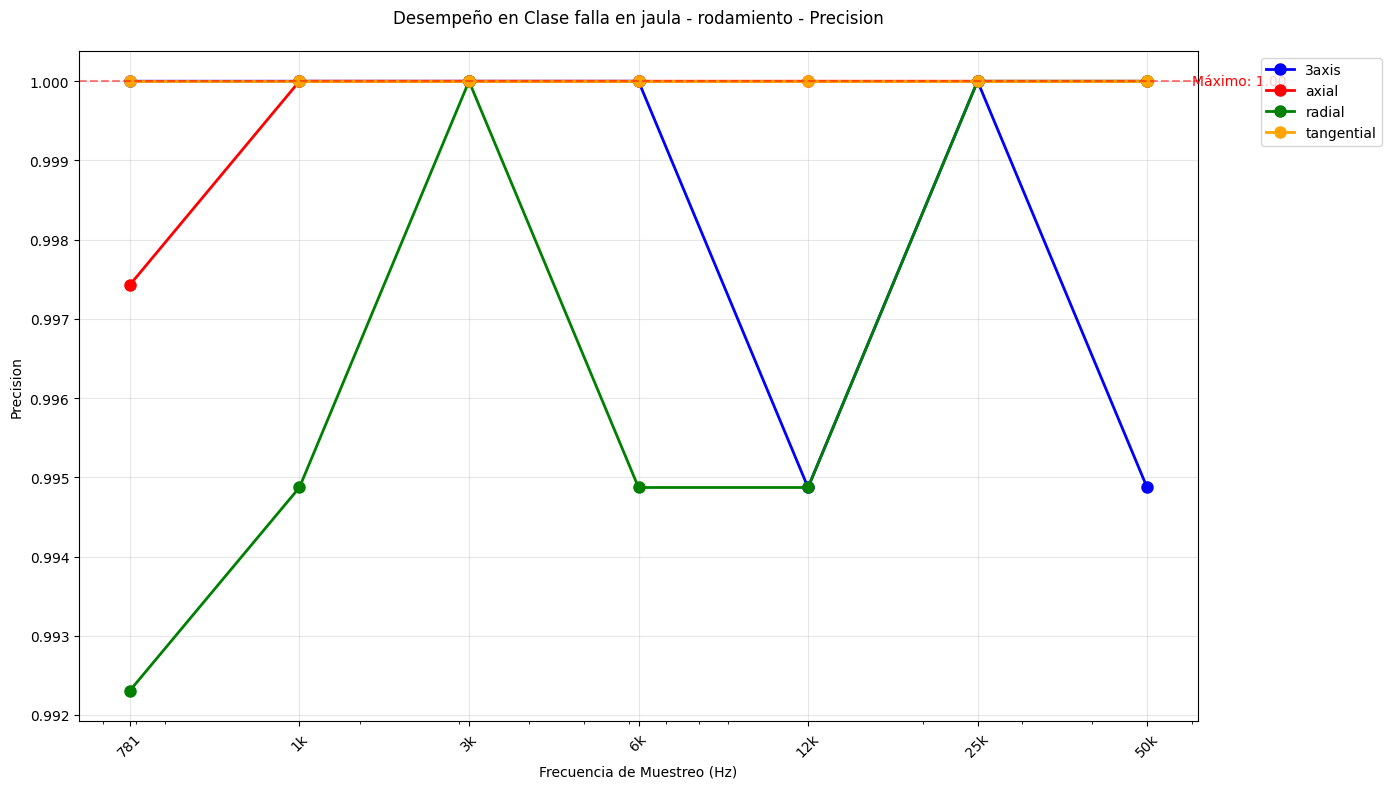

  - Generando gráfico para recall


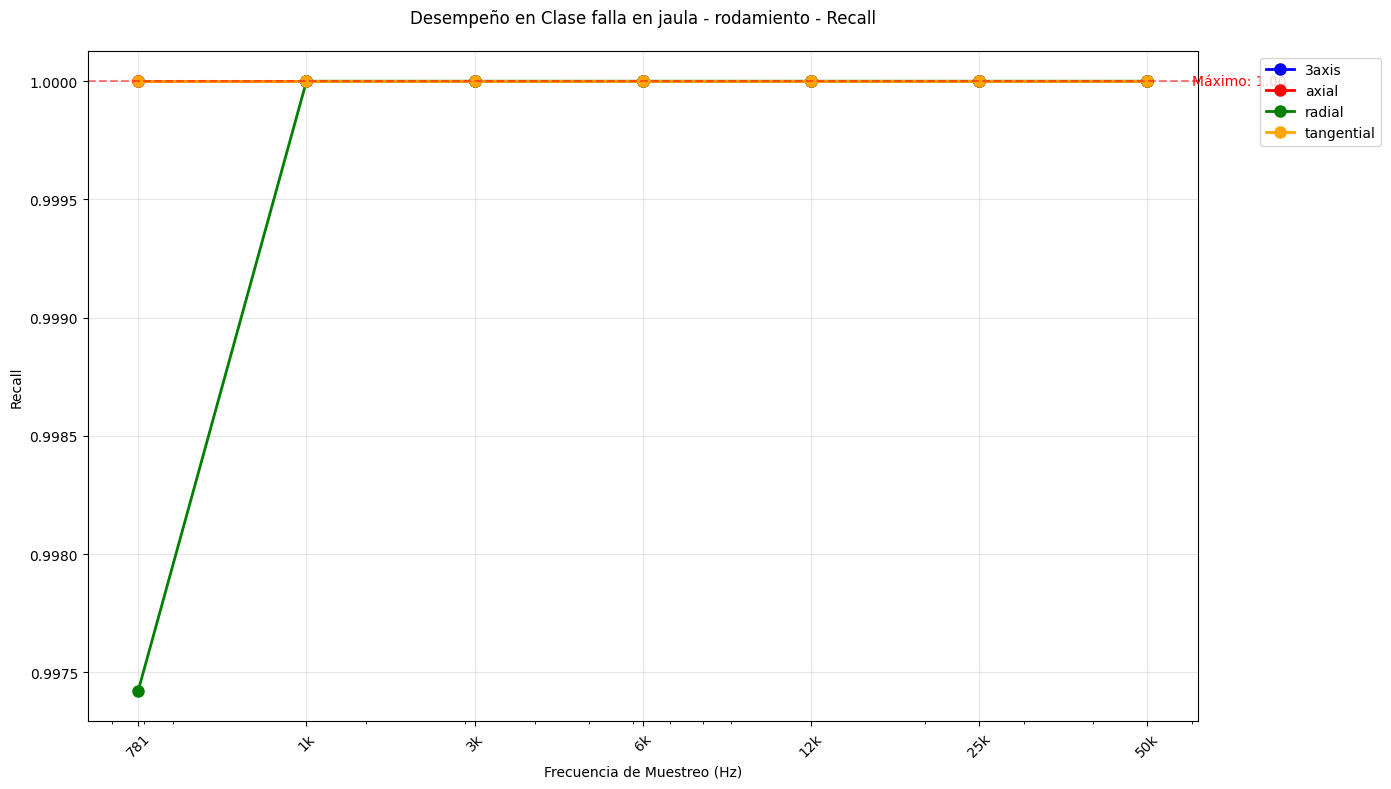

  - Generando gráfico para f1 score


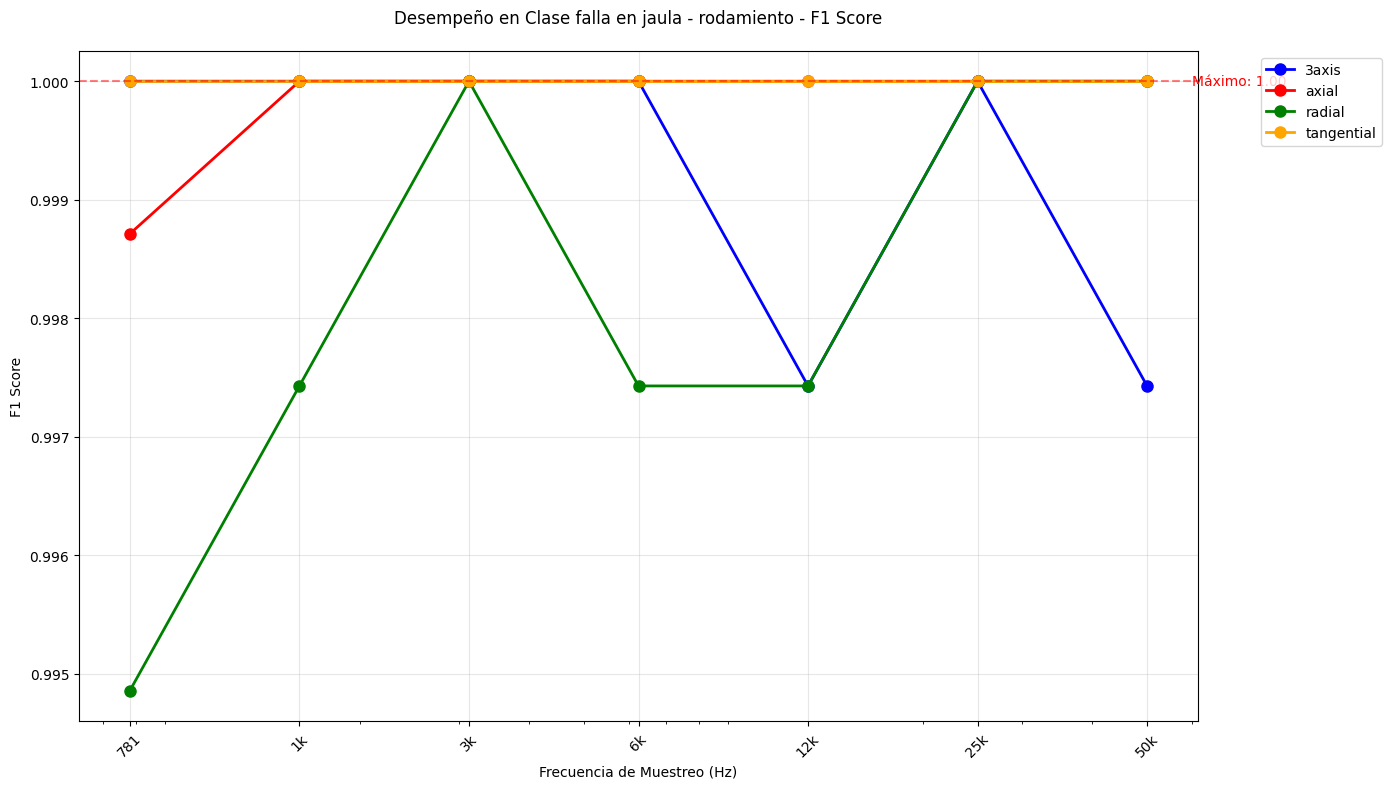


🔍 Clase 5:
  - Generando gráfico para precision


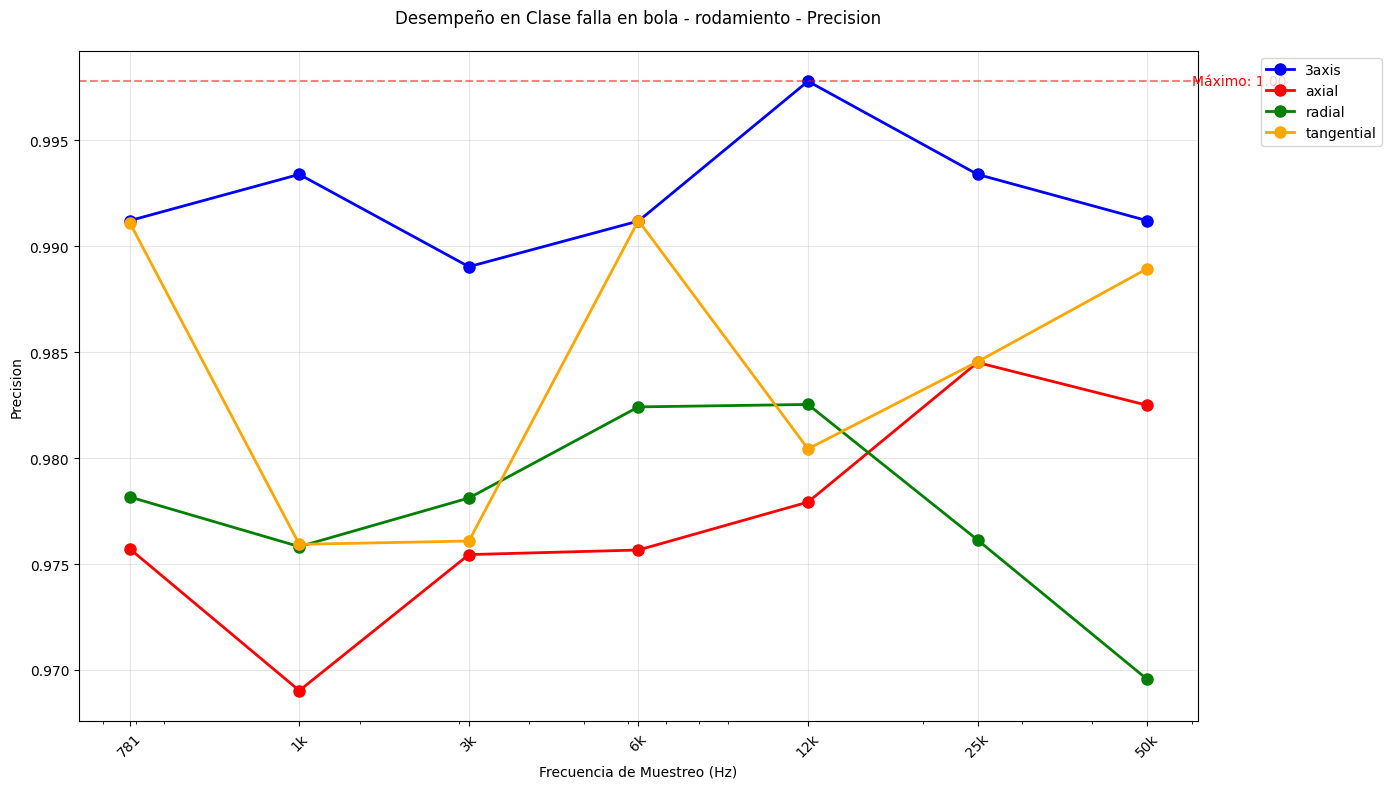

  - Generando gráfico para recall


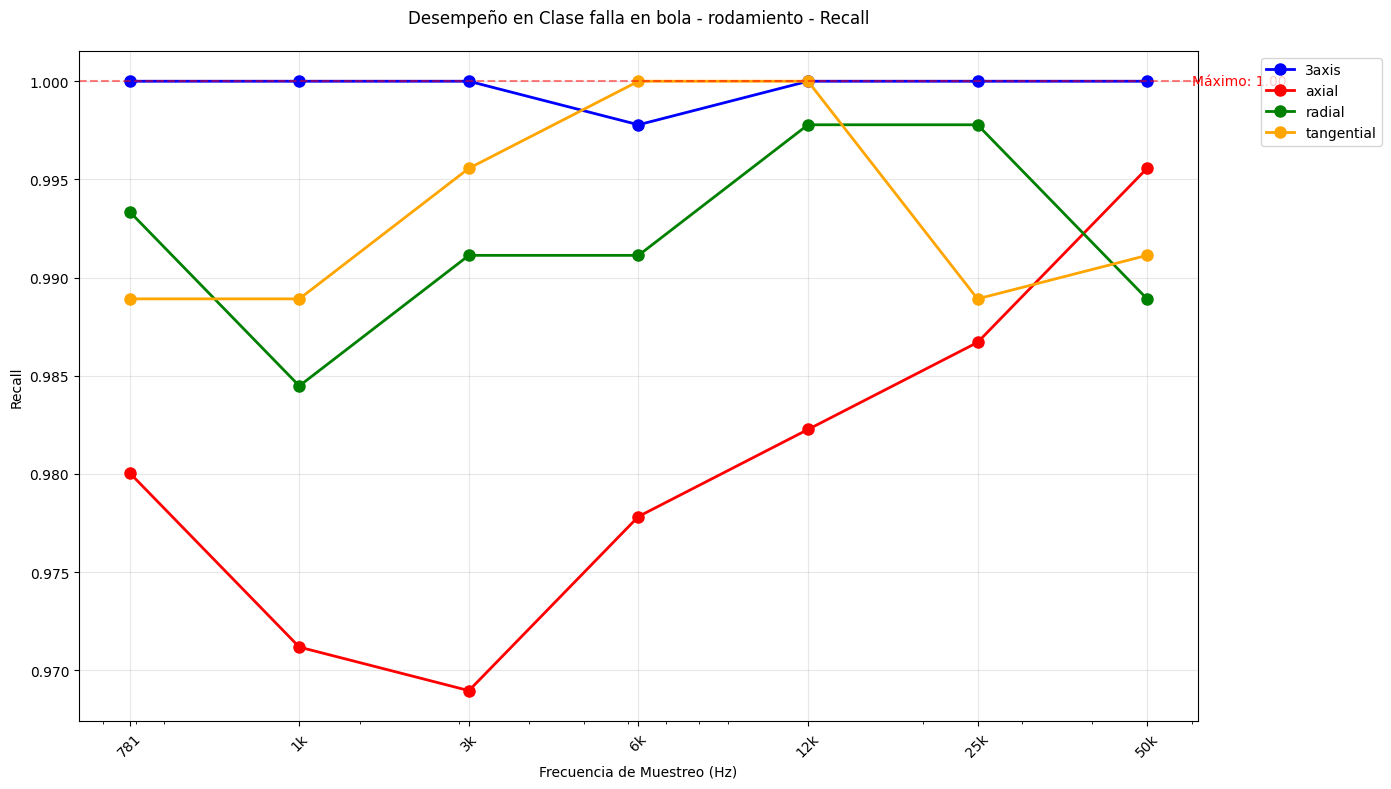

  - Generando gráfico para f1 score


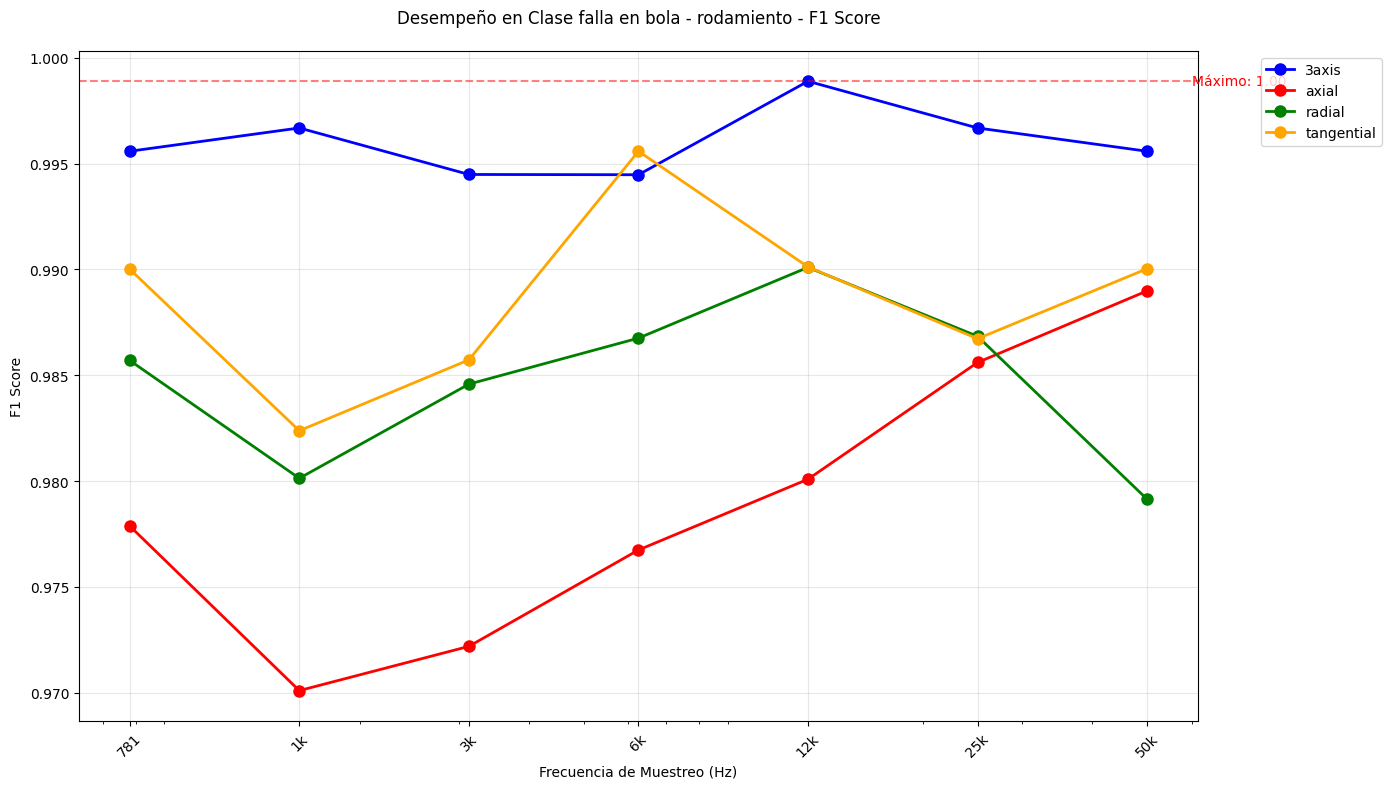


🔍 Clase 6:
  - Generando gráfico para precision


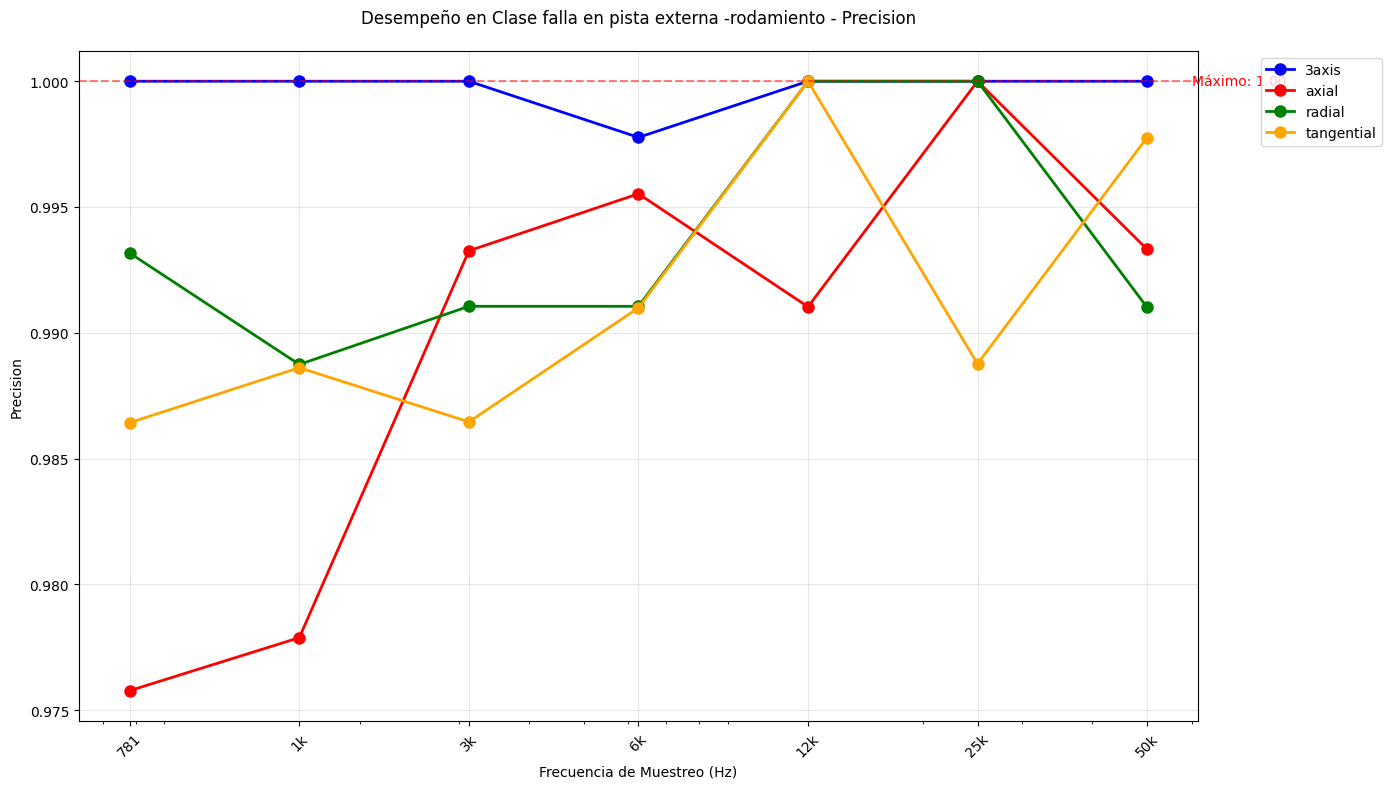

  - Generando gráfico para recall


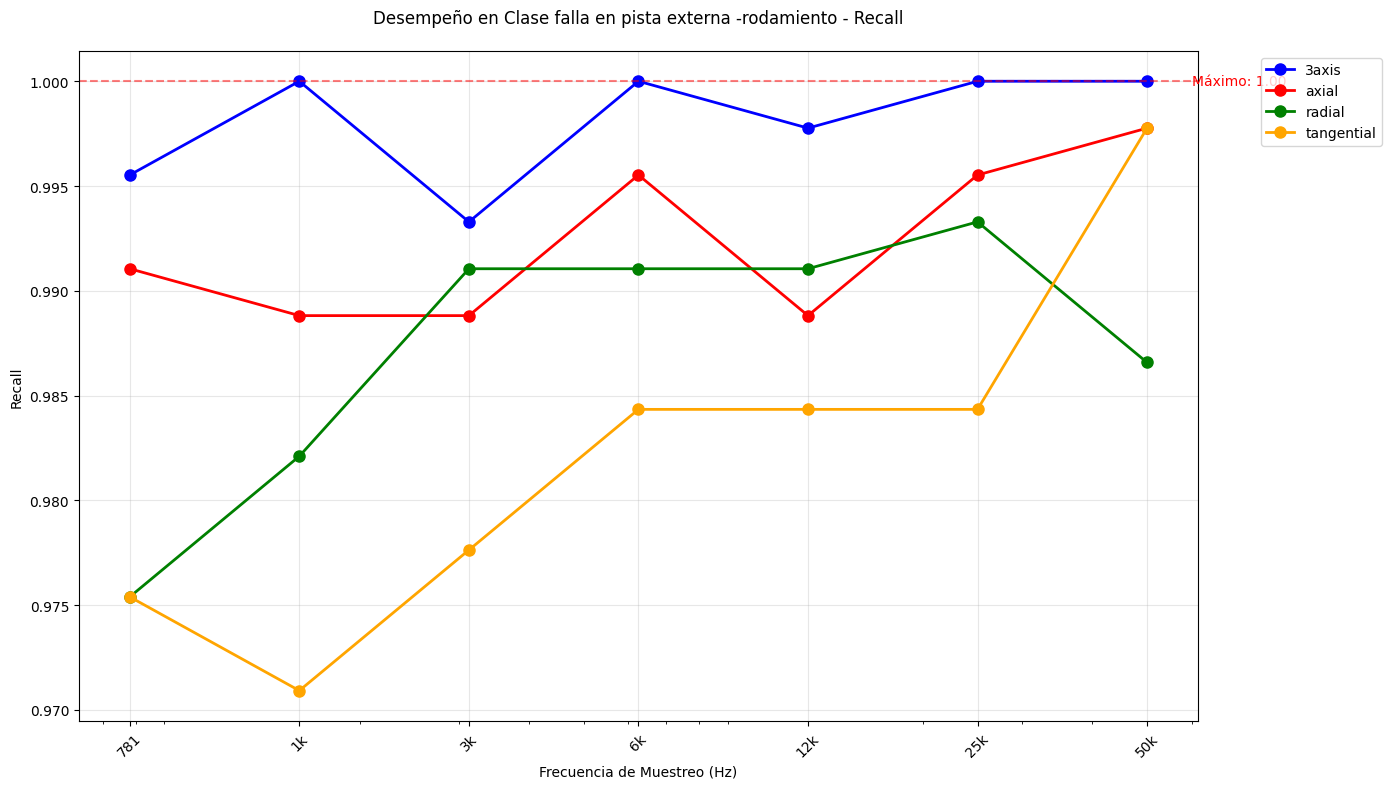

  - Generando gráfico para f1 score


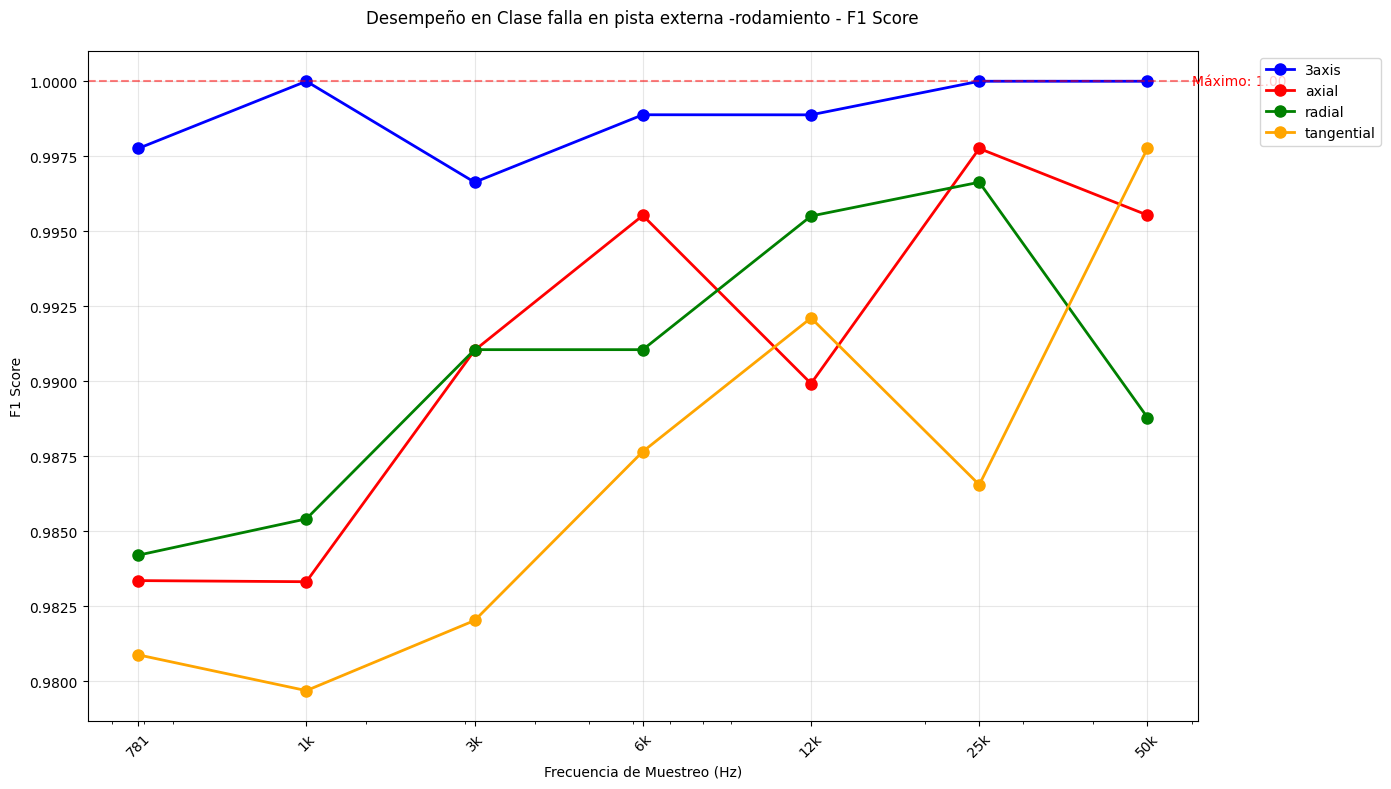

In [ ]:


# Función para graficar por clase
def plot_class_performance(class_id, metric='f1-score'):
    plt.figure(figsize=(14, 8))
    
    # Configurar colores y estilos
    sensors = df['sensor'].unique()
    colors = ['blue', 'red', 'green', 'orange']
    freqs = sorted(df['freq'].unique())
    
    # Para cada sensor
    for sensor, color in zip(sensors, colors):
        sensor_data = df[(df['sensor'] == sensor) & (df['class'] == class_id)]
        if not sensor_data.empty:
            # Ordenar por frecuencia
            sensor_data = sensor_data.sort_values('freq')
            plt.plot(sensor_data['freq'], sensor_data[metric], 
                    'o-', color=color, label=sensor, 
                    linewidth=2, markersize=8)
    
    class_name = class_dict[int(class_id)]
    plt.title(f'Desempeño en Clase {class_name} - {metric.replace("-", " ").title()}', pad=20)
    plt.xlabel('Frecuencia de Muestreo (Hz)')
    plt.ylabel(metric.replace('-', ' ').title())
    plt.xscale('log')
    plt.xticks(freqs, [f"{int(f/1000)}k" if f >= 1000 else f for f in freqs], rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Añadir línea horizontal en el máximo
    max_val = df[df['class'] == class_id][metric].max()
    plt.axhline(y=max_val, color='red', linestyle='--', alpha=0.5)
    plt.text(freqs[-1]*1.2, max_val, f'Máximo: {max_val:.2f}', 
             color='red', va='center')
    
    plt.tight_layout()
    class_folder = Path(f"figs/class_{class_id}")
    class_folder.mkdir(exist_ok=True, parents=True)
    plt.savefig(f"figs/class_{class_id}/clase_{class_id}_{metric}.png", bbox_inches='tight')
    plt.show()

# Generar gráficas para cada clase y métrica
print("\n" + "="*80)
print("📊 ANÁLISIS DE DESEMPEÑO POR CLASE")
print("="*80)

for class_id in classes:
    print(f"\n🔍 Clase {class_id}:")
    for metric in metrics:
        print(f"  - Generando gráfico para {metric.replace('-', ' ')}")
        plot_class_performance(class_id, metric)
    

In [ ]:
# Función para encontrar la mejor combinación que no sea 3axis
def get_best_non_3axis(class_data):
    # Filtrar para excluir 3axis
    non_3axis_data = class_data[class_data['sensor'] != '3axis']
    
    if not non_3axis_data.empty:
        best_idx = non_3axis_data['f1-score'].idxmax()
        return non_3axis_data.loc[best_idx]
    return None
# Crear lista para almacenar los resultados
results_list = []

for class_id in classes:
    class_data = df[df['class'] == class_id]
    
    # Obtener mejor configuración con 3axis
    best_3axis = class_data.loc[class_data['f1-score'].idxmax()] if not class_data.empty else None
    
    # Obtener mejor configuración sin 3axis
    non_3axis_data = class_data[class_data['sensor'] != '3axis']
    best_non_3axis = non_3axis_data.loc[non_3axis_data['f1-score'].idxmax()] if not non_3axis_data.empty else None
    
    class_name = class_dict[int(class_id)]
    # Preparar los datos para el DataFrame
    row = {
        'clase':class_name ,
        'best configuration 3 axis': f"{best_3axis['sensor']}@{best_3axis['freq']}Hz" if best_3axis is not None else 'N/A',
        'f1 3axis': best_3axis['f1-score'] if best_3axis is not None else None,
        'recall 3axis': best_3axis['recall'] if best_3axis is not None else None,
        'precision 3axis': best_3axis['precision'] if best_3axis is not None else None,
        'best configuration non 3 axis': f"{best_non_3axis['sensor']}@{best_non_3axis['freq']}Hz" if best_non_3axis is not None else 'N/A',
        'f1 non 3axis': best_non_3axis['f1-score'] if best_non_3axis is not None else None,
        'recall non 3axis': best_non_3axis['recall'] if best_non_3axis is not None else None,
        'precision non 3axis': best_non_3axis['precision'] if best_non_3axis is not None else None
    }
    
    results_list.append(row)

# Crear DataFrame
results_df = pd.DataFrame(results_list)

# Reordenar columnas
column_order = [
    'clase',
    'best configuration 3 axis', 'f1 3axis', 'recall 3axis', 'precision 3axis',
    'best configuration non 3 axis', 'f1 non 3axis', 'recall non 3axis', 'precision non 3axis'
]
results_df = results_df[column_order]

# Calcular diferencias
results_df['diff f1'] = results_df['f1 3axis'] - results_df['f1 non 3axis']
results_df['diff %'] = (results_df['diff f1'] / results_df['f1 3axis']) * 100

# Guardar a CSV
results_df.to_excel('comparacion_3axis_vs_alternativas.xlsx', index=False, float_format='%.3f')

# Mostrar el DataFrame
print("\n" + "="*80)
print("📊 COMPARACIÓN 3axis vs ALTERNATIVAS POR CLASE")
print("="*80)
print(results_df)

PermissionError: [Errno 13] Permission denied: 'comparacion_3axis_vs_alternativas.xlsx'